# Impacts of Supernovae on Reaccretion, Infall
## Introducing Analysis of Gas Reaccretion
`-- Leo Lonzarich, 1 April 2022 // [Updated 11-5-22] --`

---


### Table of Contents
- [Defining Infall](#infall)
    - [Discharge and Reaccretion](#disreacc)
- [Assessing Gas Flows](#flows)
    - [SN-heating Fractions](#discharged)
    - [Gas Outflow](#outflows)


### General Comments on Data/Contents of this Noteboook
- This is the second installment of work tied to Spring 2022 research under **Professor Charlotte Christensen** (Grinnell College, IA)
- See `SimKeys.md` for comprensive explanation of intrinsic particle properties (as found when calling `[particles].keys()`) and standard units of measure.


**The Data (Lonzarich):**

- `discharged`: Gas particles that have been removed from the disk of their respective satellite galaxy. This includes both gas moved to halo, and that moved beyond the virial radius. (Properties given for **timestep after discharge event**.)
- `predischarged`: A collection of the same particles in `discharged`, but instead giving the properties of each particle prior to their discharge event (thereby allowing pre- and post-discharge comparisons).
- `heated`: Gas particles in `discharged` that experienced supernova(e) heating (functionally, their 'cooling' was turned off) in the timestep prior to being discharged. (Note: this dataset can be also be obtained by selecting particles from `discharged` with `snHeated==True`.)
- `preheated`: Similar to `predischarged`; Consists of the same particles in `heated`, but with properties of each particle for the timestep prior to discharge.
<br><br>
- `accreted`: Gas particles in the halo or beyond the virial radius of a satellite that are accreted onto the satellite's disk. (Properties given for **timestep following accretion event**.) Note that this includes particles that were previously discharged from the satellite's disk, and those that were not. 
- `reaccreted`: A subset of `accreted`; Gas particles in the halo or beyond the virial radius of a satellite as a result of a prior discharge event that are reaccreted onto the satellite's disk. (Properties given for **timestep following reaccretion event**.)


In [3]:
import pylab
import pynbody
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import tqdm as tqdm


from astropy import units
from astropy import constants as c

import warnings
warnings.filterwarnings("ignore")

from compiler import *
from analysis import *

In [4]:
# helpful fix in case TeX breaks in pyplots.
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [5]:
# quick check to ensure all selected gas particles are accounted for.
path = f'{rootPath}Stellar_Feedback_Code/SNeData/discharged_particles.hdf5'
with pd.HDFStore(path) as hdf:
    keys = np.array([h[1:] for h in hdf.keys()])

print(len(keys), 'Available Keys:\n', *keys)

19 Available Keys:
 h148_12 h148_249 h148_251 h148_27 h148_282 h148_34 h148_38 h148_55 h148_65 h229_14 h229_18 h229_20 h229_22 h229_49 h242_21 h242_38 h242_69 h329_117 h329_29


In [6]:
# importing all data.
predischarged, hot_predischarged, discharged = read_all_discharged()
all_accreted, reaccreted = read_accreted()

# gas SN-heated/unheated prior to discharge.
hot = discharged[discharged['snHeated']==True]  # heated.
cold = discharged[discharged['snHeated']==False]  # unheated.

sngas = read_sngas()  # all SN-heated

> Returning (predischarged, discharged, hot_predischarged) for all satellites <
> Returning (accreted, reaccreted) for all satellites <
> Returning (SN-heated gas) for all satellites <


In [8]:
# quick calc. for ubiquitous weights in plotting.
@pynbody.derived_array
def wt(*gas):
    if len(gas) == 1:
        return np.array(gas[0]['mass'] / gas[0]['mass'].sum())
    
    else:
        return np.array(gas[0]['mass'] / gas[1]['mass'].sum())

In [87]:
# satellites ordered by virial mass from largest to smallest.

keys_mass = ['h148_27','h229_18','h148_282','h242_69','h242_21','h148_38','h148_65',
             'h148_12','h229_14','h148_34','h148_55','h148_251','h148_249','h229_22',
             'h229_20','h229_49','h329_29','h329_117','h242_38']

## Point at Infall: Distance Between Satellite and Host <a class="anchor" id="infall"></a>

#### Why?

To kickoff the second stage in SNe feedback analysis, we are first required to identify location during satellite infall for each gas particle. When a distant dwarf galaxy becomes gravitationally bound to a Milky-Way-mass host galaxy, it develops an approach vector oriented towards the COM of the host -- it is this approach to the host COM that we term "satellite infall", and it is the distance of the satellite's COM to the host's COM that we define as "point at infall". 

Thus, for each gas particle, we wish to find point at infall with the end goal being that this allows us to more readily discriminate between gas particles. What is more, however, we know from past work (see Akins et al. 2021) that ram pressure stripping (RPS) efficiency increases with proximity of a satellite galaxy to its host. Therefore, discriminating on point at infall presents a method for screening gas for RPS and possibly untangle RPS from SNe feedback stripping mechanisms.

#### How? 

Locating point at infall data, which we will lovingly term PAI (or `pai`), is a relatively straightforward excercise, and we will normalize `pai` by the virial radius of the host galaxy, `Rvir`, which will effectively give us a percent distance of a gas particle's satellite to the center of its host:

$$
pai = \frac{\text{radial distance from sat. to host}}{\text{virial radius of host}} .
$$

____
____

### Relations Between PAI and Gas Discharge, Reaccretion, Permanent Expulsion  <a class="anchor" id="disreacc"></a>

___


In [9]:
# callable derivation for satellite distance from host:
@pynbody.derived_array
def pai(gas):
    return np.array(np.sqrt((gas['host_Xc'] - gas['sat_Xc'])**2
                            + (gas['host_Yc'] - gas['sat_Yc'])**2
                            + (gas['host_Zc'] - gas['sat_Zc'])**2
                           )/ gas['hostRvir']
                   )


# callable for satellite infall time:
from scipy import interpolate

@pynbody.derived_array
def infall(gas, key):
    gas1 = gas[gas.key==key]  # will get errors if not using array of all gas.
    gas1 = gas1.sort_values(by=['time'])
    
    pai1 = np.unique(pai(gas))
    time = np.unique(gas.time)

    f = interpolate.interp1d(pai1, time)

    return f(1)  # finding time when at 1 Rvir of host 

Notes on terminology:
- $R_{vir}$ is the virial radius of the host galaxy.
- $M_{\{gas\}}$ refers to the mass of gas either discharged or reaccreted (where applicable in the plots) corresponding to a particular parameter.
- We use $\sum M_{dsrg}$ and $\sum M_{reacc}$ to denote the cumulative mass of all discharged and reaccreted gas particles, respectively; $\sum M_{gas}$ is used for some plot axes where, again, different sets of gas are plotted on the same axes.

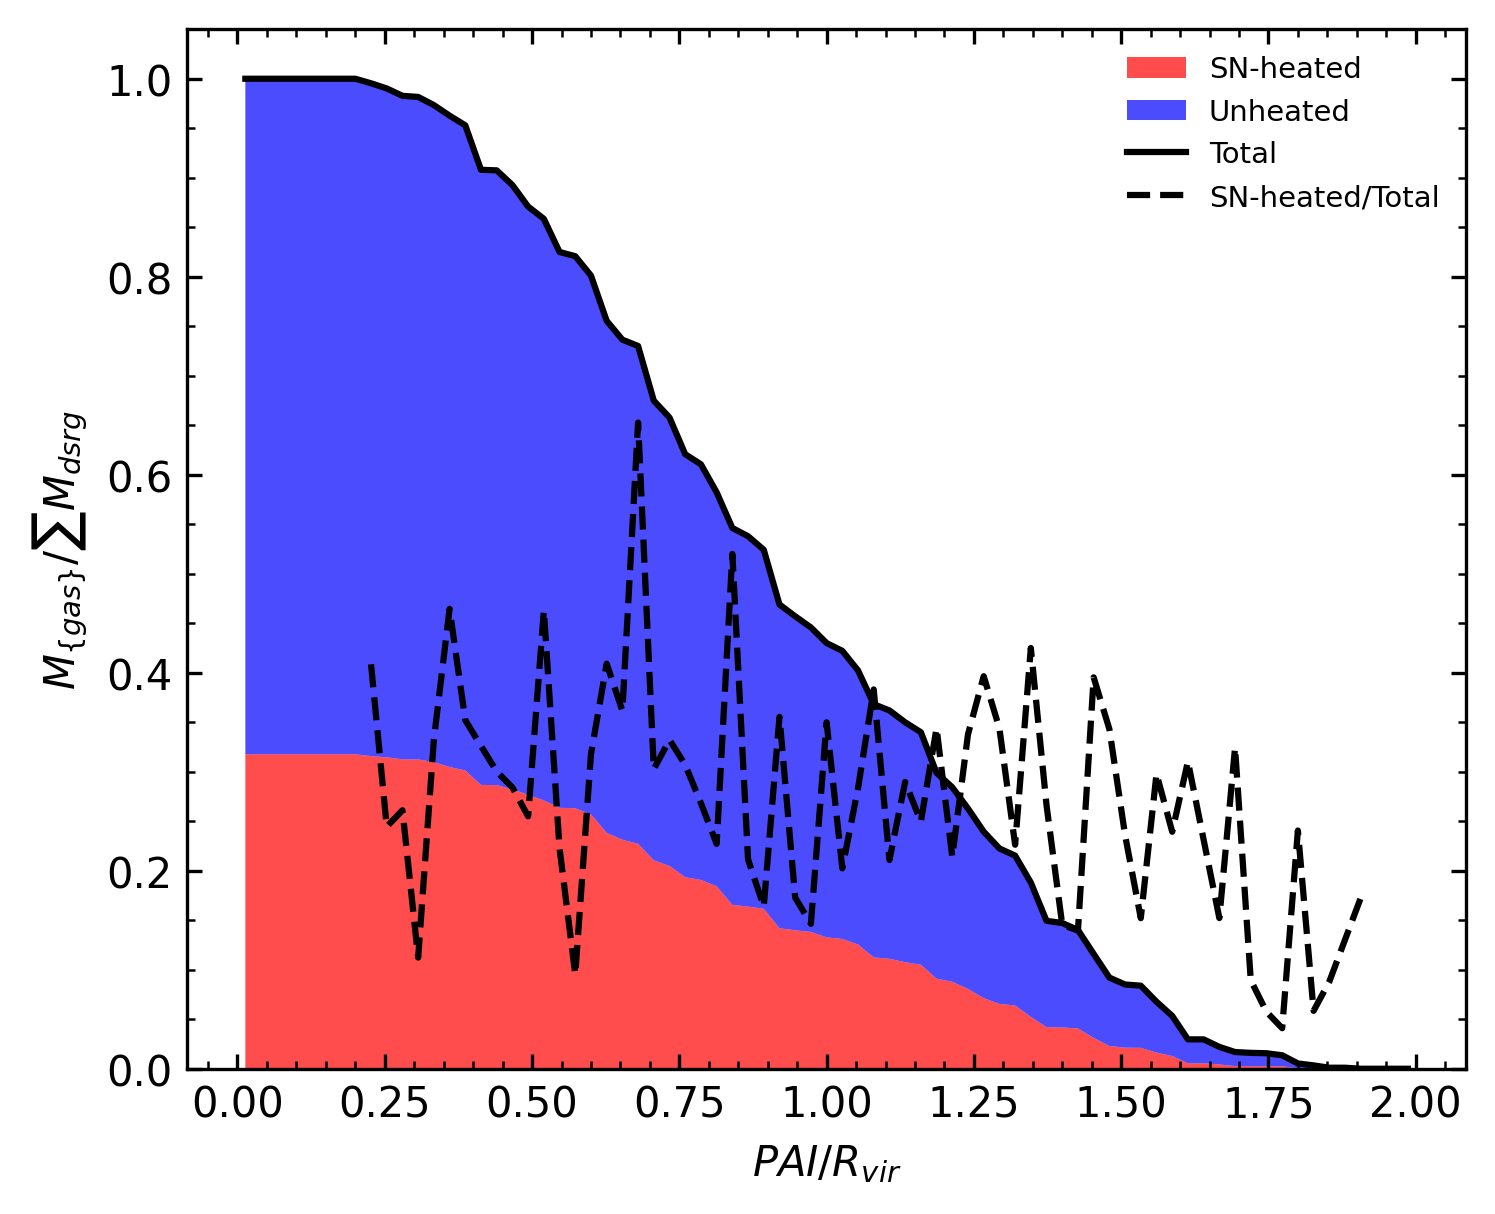

In [18]:
# identifying where discharged gas is removed to as a function of PAI.
bins = 75
fig, ax = plt.subplots(1,1, dpi=300, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)

y1, x = np.histogram(pai(hot), bins=bins, weights=wt(hot,discharged),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(cold), bins=bins, weights=wt(cold,discharged),
                     range=(0, 2))
sum2 = np.cumsum(y2)
ax.stackplot(bincenters, sum1[-1]-sum1, sum2[-1]-sum2, alpha=0.7,
             colors=['r', 'b'], labels=['SN-heated', 'Unheated'])         

y3, x = np.histogram(pai(discharged), bins=bins, weights=wt(discharged),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum3 = np.cumsum(y3)
ax.plot(bincenters, sum3[-1]-sum3, alpha=1.0, c='black', label='Total')

ax.plot(bincenters[y3>0], (y1/y3)[y3>0], linestyle='--', c='black',
        label='SN-heated/Total')

# ax.set_title('Gas Discharged Over Infall Distances', fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)

ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
# ax.grid(alpha=0.1, zorder=-1000)

ax.legend(frameon=False, fontsize=7)

plt.savefig('S22plots/PAIperRvir.pdf')
plt.show()

Note: The rising edge that appears between ~1.50 and 2.00 $PAI/R_{vir}$ is likely due to the low relative particle counts in this region.

In [19]:
# computing avg. of SN-heated/Total (dashed line in above plot):
(y1/y3)[y3>0].mean()

0.27219090255073675

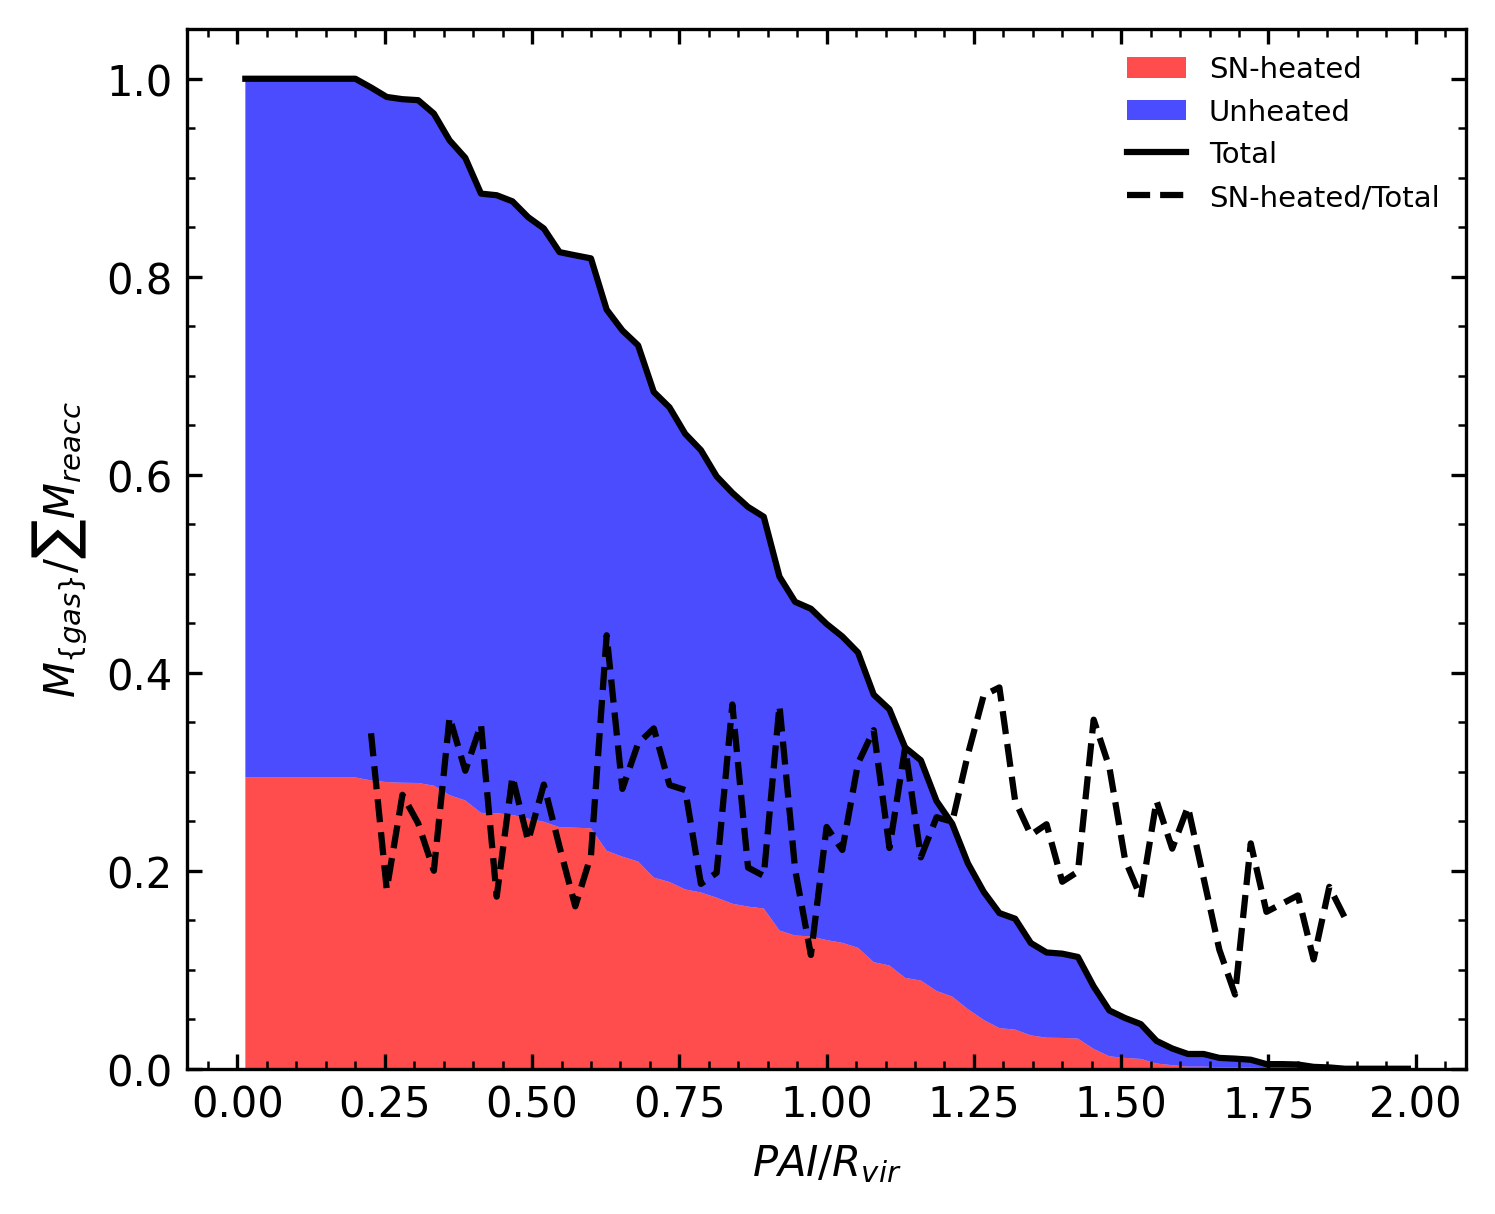

In [20]:
# Basic visualization of where reaccreted gas is removed to as function of POI.
hot_reac = reaccreted[reaccreted.snHeated==True]
cold_reac = reaccreted[reaccreted.snHeated==False]

bins = 75
fig, ax = plt.subplots(1,1, dpi=300, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)


y1, x = np.histogram(pai(hot_reac), bins=bins, weights=wt(hot_reac,reaccreted),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(cold_reac), bins=bins, weights=wt(cold_reac,reaccreted),
                     range=(0, 2))
sum2 = np.cumsum(y2)
ax.stackplot(bincenters, sum1[-1]-sum1, sum2[-1]-sum2, alpha=0.7,
             colors=['r', 'b'], labels=['SN-heated', 'Unheated'])         

y3, x = np.histogram(pai(reaccreted), bins=bins, weights=wt(reaccreted), 
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum3 = np.cumsum(y3)
ax.plot(bincenters, sum3[-1]-sum3, alpha=1.0, c='black', label='Total')

ax.plot(bincenters[y3>0], (y1/y3)[y3>0], linestyle='--', c='black', label='SN-heated/Total')

# ax.set_title('Gas Reaccretion Over Infall Distances',
#              fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{reacc}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)

ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
# ax.grid(alpha=0.1, zorder=-1000)

ax.legend(frameon=False, fontsize=7)

plt.savefig('S22plots/PAIperRvir_reac.pdf')
plt.show()

Repeating the plots above, but now for gas that was discharged and not reaccreted. We find this subset of gas, which will be called `expelled`, by making and applying a mask to the discharge data.

In [33]:
expelled

time      pid       rho           temp          mass  coolontime  \
99277   11.214915  2202002  0.000120   53035.859375  28366.376150   10.908183   
79674   10.767100  4073949  0.058975    9752.045898  26835.758536    0.000000   
79678   10.767100  4340176  0.057253    9207.494141  27066.785805   10.685118   
136776  12.507856  6936050  0.000011   48991.417969  27736.528803   12.258361   
145772  12.938837  6988228  0.000012  119505.640625  27141.024771   12.810553   
...           ...      ...       ...            ...           ...         ...   
10743    8.413543  6627480  0.016590   12876.310547  26687.942049    2.931124   
7143     8.090307  6627481  0.001024   20130.953125  26746.271801    7.794526   
21574    9.060013  6627712  0.000071  408574.468750  26672.241803    4.748210   
17977    8.736778  6627722  0.011231   34972.496094  26609.252579    0.000000   
10782    8.413543  6627757  0.073837   11142.910156  26583.791275    0.000000   

                r  r_per_Rvir          x          y  ...  sat_disk  sat_halo  \
99277    6.693904    0.162781   0.587731  -0.193634  ...     False      True   
79674    0.870948    0.021428  -0.690207  -0.460012  ...     False      True   
79678    0.860939    0.021182  -0.582543  -0.527218  ...     False      True   
136776  19.134719    0.448190  18.108089  -4.812728  ...     False     False   
145772  19.112913    0.442656   6.628961 -16.784898  ...     False     False   
...           ...         ...        ...        ...  ...       ...       ...   
10743    1.354843    0.055117  -0.669973   1.063307  ...     False      True   
7143     4.248400    0.172406  -4.135189  -0.921959  ...     False      True   
21574   56.000982    2.464839  19.765341 -27.934206  ...     False     False   
17977    1.378329    0.093829  -1.241353  -0.255424  ...     False      True   
10782    1.321416    0.053757   1.003322  -0.035879  ...     False      True   

        host_disk  host_halo  other_sat    IGM  sat_Mvir       angle  \
99277       False      False      False  False       NaN  131.989918   
79674       False      False      False  False       NaN   11.985810   
79678       False      False      False  False       NaN   18.176142   
136776      False      False      False   True       NaN   27.556419   
145772      False      False      False   True       NaN   27.405719   
...           ...        ...        ...    ...       ...         ...   
10743       False      False      False  False       NaN   58.457262   
7143        False      False      False  False       NaN  129.768798   
21574       False       True      False  False       NaN   10.290002   
17977       False      False      False  False       NaN   34.899107   
10782       False      False      False  False       NaN  103.847700   

        snHeated      key  
99277       True  h148_12  
79674      False  h148_12  
79678       True  h148_12  
136776      True  h148_12  
145772      True  h148_12  
...          ...      ...  
10743      False  h329_29  
7143        True  h329_29  
21574      False  h329_29  
17977      False  h329_29  
10782      False  h329_29  

[88060 rows x 64 columns]

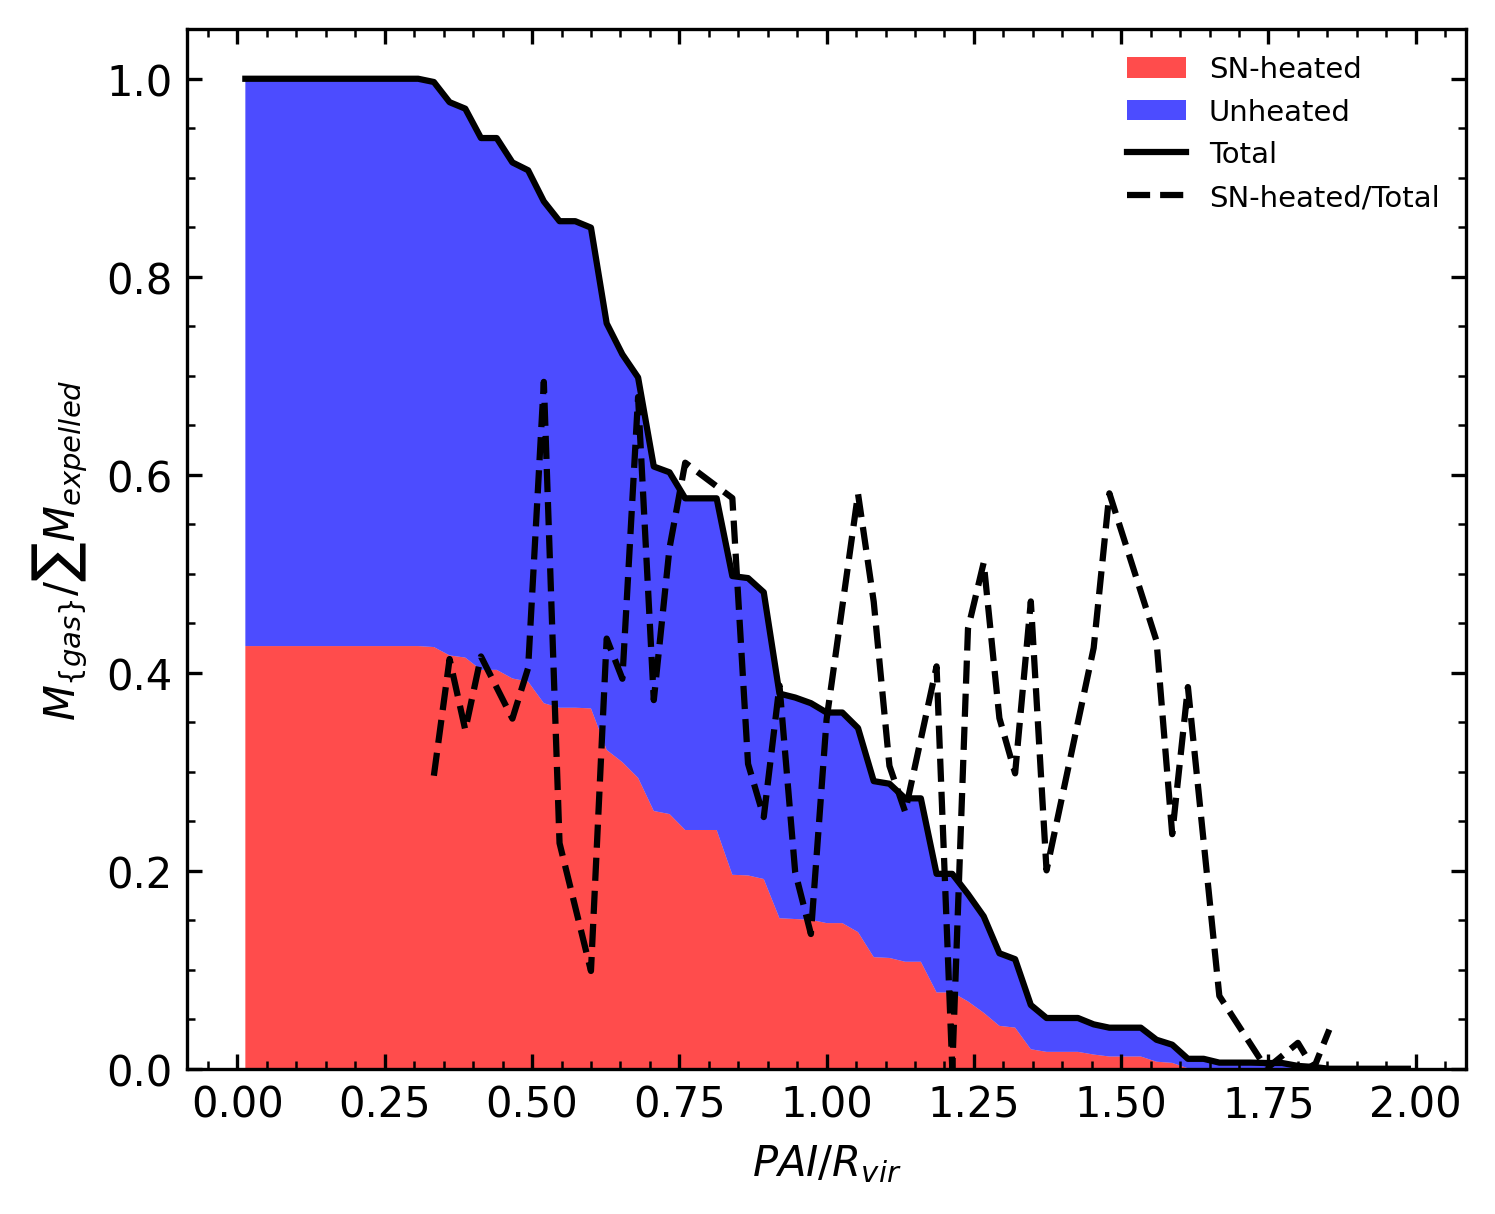

In [22]:
y = np.array(discharged['pid'])  # particle ids of discharged gas...
x = np.array(reaccreted['pid'])  # ...and for reaccreted.

# applying mask:
index = np.argsort(x)
sorted_x = x[index]  # Sorted list of ids pre discharged                        
sorted_index = np.searchsorted(sorted_x, y)
yindex = np.take(index, sorted_index, mode="clip")
mask = x[yindex] != y
result = np.ma.array(yindex, mask=mask)
expelled = discharged.iloc[result[result.mask].data]  # permanently discharged gas.

hot_exp = expelled[expelled['snHeated']==True]  # SN-heated, expelled gas.
cold_exp = expelled[expelled['snHeated']==False]  # unheated, expelled.


bins = 75
fig, ax = plt.subplots(1,1, dpi=300, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)

y1, x = np.histogram(pai(hot_exp), bins=bins, weights=wt(hot_exp,expelled),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(cold_exp), bins=bins, weights=wt(cold_exp,expelled),
                     range=(0, 2))
sum2 = np.cumsum(y2)
ax.stackplot(bincenters, sum1[-1]-sum1, sum2[-1]-sum2, alpha=0.7,
             colors=['r', 'b'], labels=['SN-heated', 'Unheated'])         

y3, x = np.histogram(pai(expelled), bins=bins, weights=wt(expelled),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum3 = np.cumsum(y3)
ax.plot(bincenters, sum3[-1]-sum3, alpha=1.0, c='black', label='Total')

ax.plot(bincenters[y3>0], (y1/y3)[y3>0], linestyle='--', c='black',
        label='SN-heated/Total')

# ax.set_title('Gas Permanently Discharged Over Infall Distances', fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{expelled}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)

ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
# ax.grid(alpha=0.1, zorder=-1000)

ax.legend(frameon=False, fontsize=7)

plt.savefig('S22plots/PAIperRvir_expelled.pdf')
plt.show()

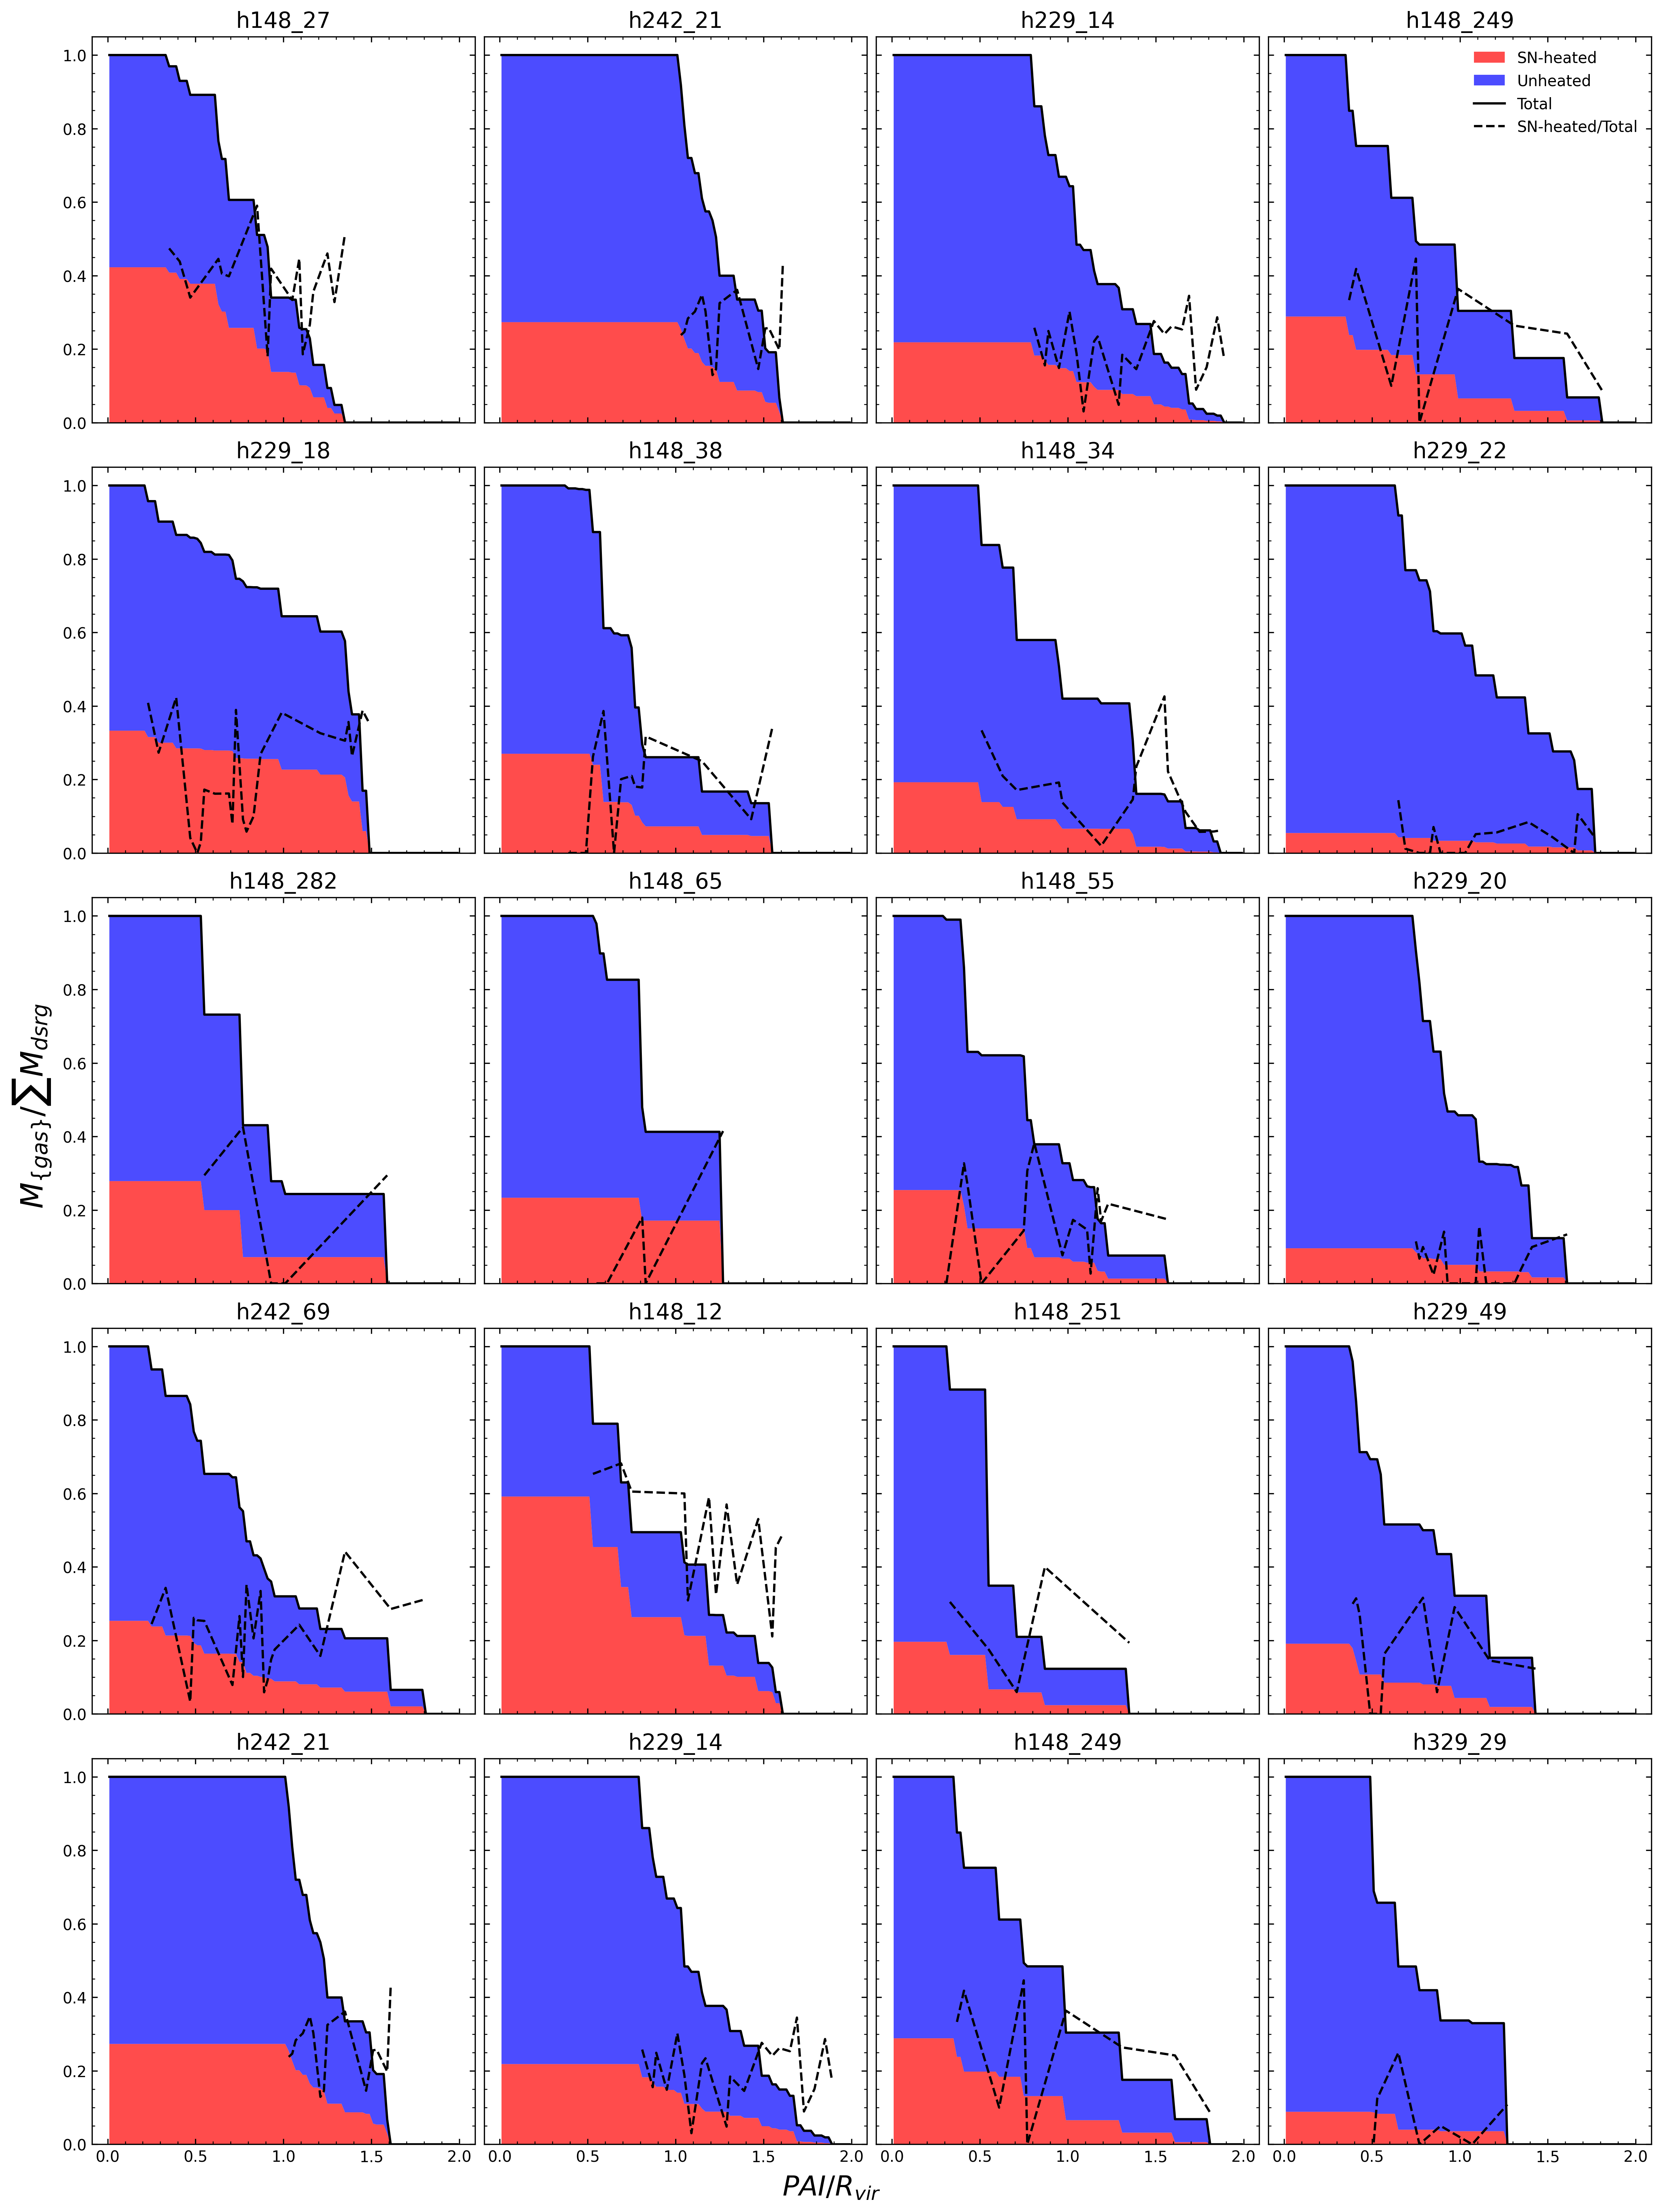

In [117]:
# Making panel of the discharge plot above for each satellite.

bins = 100
fig, ax = plt.subplots(5, 4, dpi=300, figsize=(15,20), sharex='col', sharey='row', 
                       constrained_layout=True)  # figsize=(20,10)

keys = keys_mass #get_keys()

for i in range(5): 
    for j in range(0,4):
        k = 4*j + i  # flip i and j until we have a 20th satellite.
        hot1 = hot[hot['key']==keys[k]]
        cold1 = cold[cold['key']==keys[k]]
        discharged1 = discharged[discharged['key']==keys[k]]

        y1, x = np.histogram(pai(hot1), bins=bins, weights=wt(hot1,discharged1),
                             range=(0, 2))
        bincenters = 0.5*(x[1:] + x[:-1])
        sum1 = np.cumsum(y1)
        y2, x = np.histogram(pai(cold1), bins=bins, weights=wt(cold1,discharged1),
                             range=(0, 2))
        sum2 = np.cumsum(y2)
        ax[i, j].stackplot(bincenters, sum1[-1]-sum1, sum2[-1]-sum2, alpha=0.7,
                     colors=['r', 'b'], labels=['SN-heated', 'Unheated'])

        y3, x = np.histogram(pai(discharged1), bins=bins, weights=wt(discharged1),
                             range=(0, 2))
        bincenters = 0.5*(x[1:] + x[:-1])
        sum3 = np.cumsum(y3)
        ax[i, j].plot(bincenters, sum3[-1]-sum3, alpha=1.0, c='black', label='Total')

        ax[i, j].plot(bincenters[y3>0], (y1/y3)[y3>0], linestyle='--', c='black',
                   label='SN-heated/Total')
        
        # setting axes, titles, etc.
        ax[i, j].set_title(f'{keys[k]}', fontsize='x-large')
#         ax[i, j].set_title(f'{keys[k]}', fontsize='large', y=1.0, pad=-14)
        
        ax[i, j].tick_params(direction='in', which='both', top=True, right=True)
        ax[i, j].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
        ax[i, j].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

# fig.suptitle('Accumulation of Gas Discharge Events with Point at Infall', fontsize=26)
fig.supxlabel('$PAI / R_{vir}$', fontsize=18)
fig.supylabel('$M_{\{gas\}} / \sum M_{dsrg}$', fontsize=20)

ax[0, 3].legend(frameon=False, fontsize='medium', loc='best')

plt.savefig('S22plots/PAIperRvir_panel.pdf')
plt.show()

## SN-heated Gas Fractions, Gas Flows <a class="anchor" id="flows"></a>

We give two treatments in this section:
1. Fraction of SN-heated, discharged gas reaccreted at each $PAI/R_{vir}$;

2. Fraction of all SN-heated gas discharged from its satellite (again, at each $PAI/R_{vir}$)

___
___


### SN-heated Gas Represented at different PAI <a class="anchor" id="discharged"></a>

Plotting Proportion of SN-heated gas discharged per all SN-heated gas at each PAI.

___


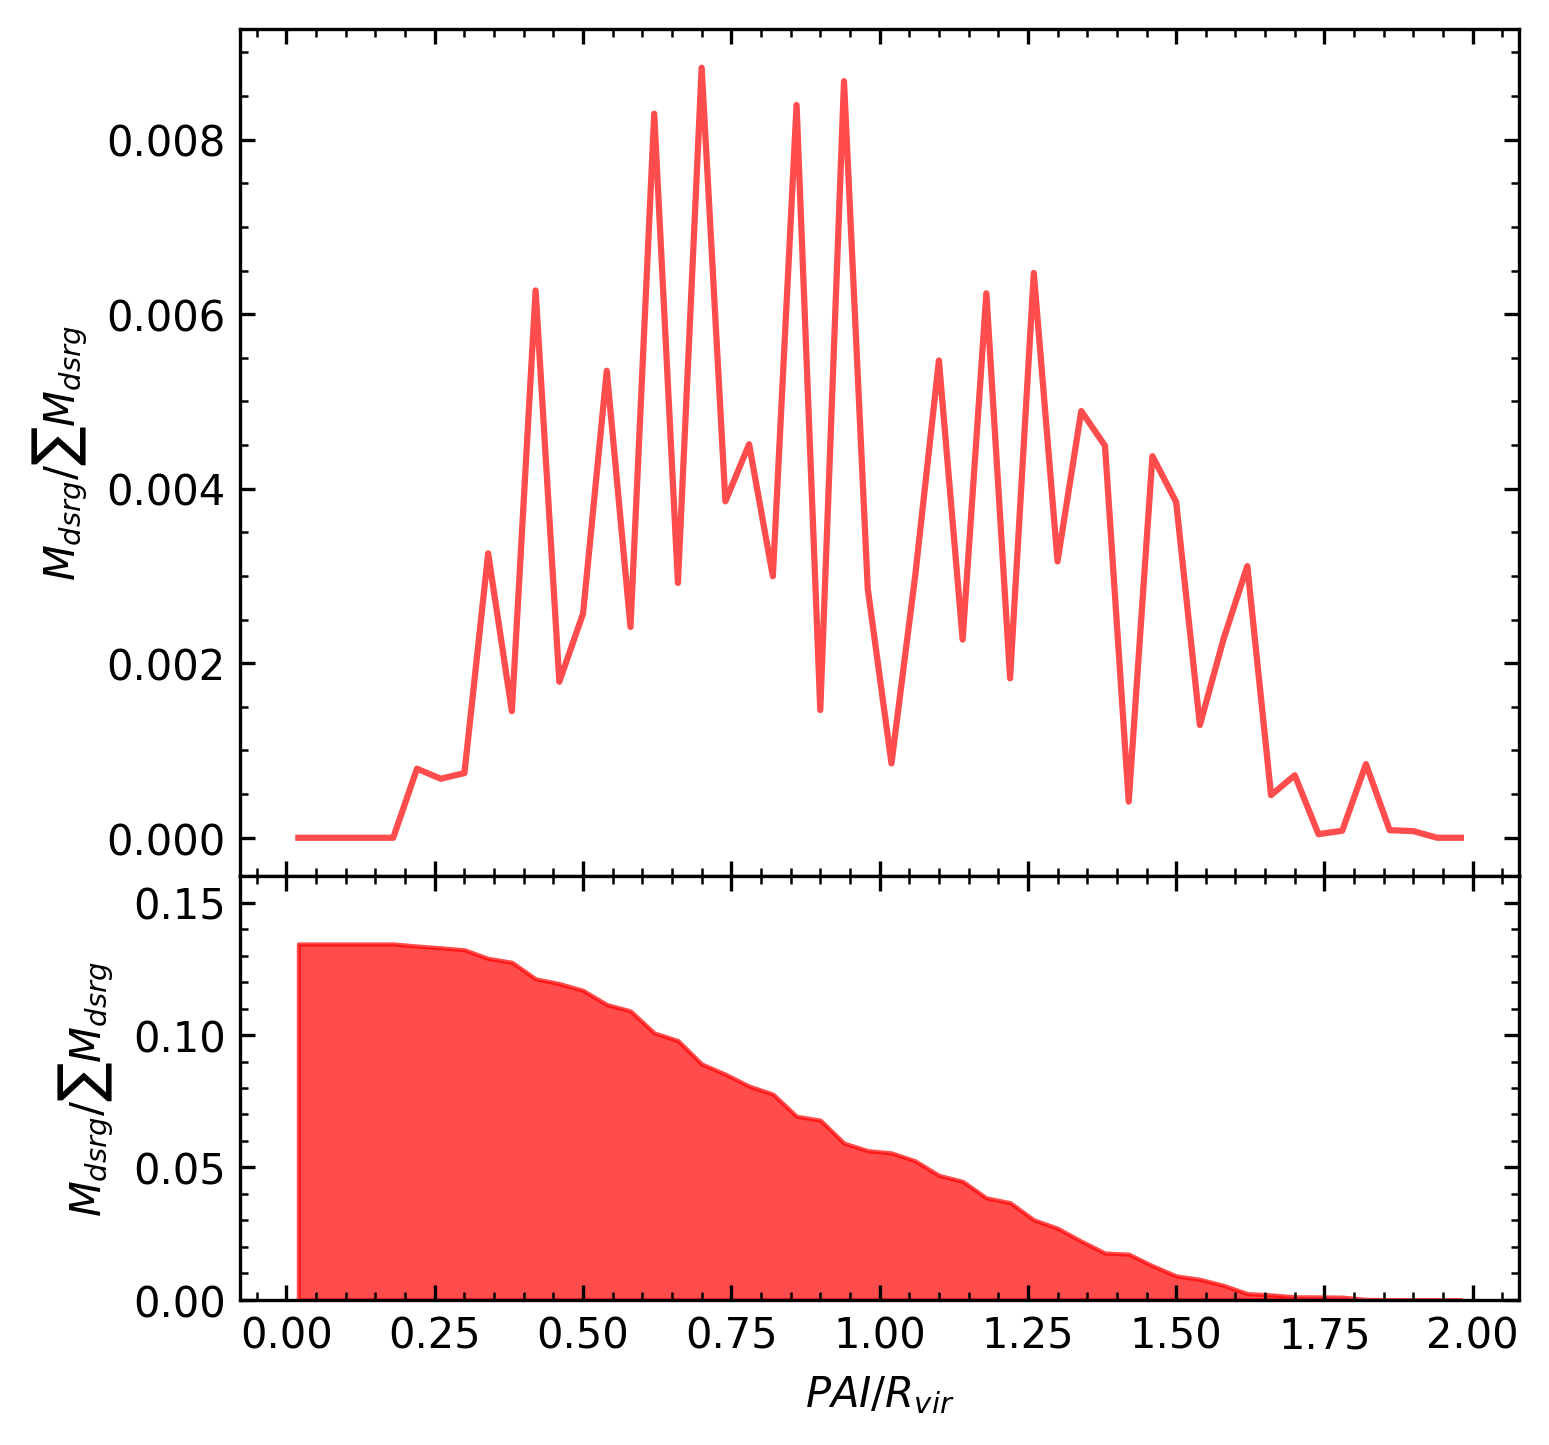

In [135]:
hot_dsrg = discharged[discharged.snHeated==True]


bins = 50
fig = plt.figure(dpi=300, figsize=(5.5,5.5), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0) 
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)


y1, x = np.histogram(pai(hot_dsrg), bins=bins, weights=wt(hot_dsrg,sngas),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)

ax0.plot(bincenters, y1, alpha=0.7, color='r')         
ax1.stackplot(bincenters, sum1[-1]-sum1, alpha=0.7, color='r')    

# ax[1].text(0, 0.9, 'Accumulation of Discharged Gas with Infall Distance')


# ax0.set_title('SN-heated Gas Discharged with Infall Distances',
#               fontsize='medium')
ax0.set_xlabel(r'$PAI / R_{vir}$')
ax0.set_ylabel('$M_{dsrg} / \sum M_{dsrg}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)
                                                                                    
ax0.tick_params(direction='in', which='both', top=True, right=True)
ax0.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax0.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.0005))
# ax.grid(alpha=0.1, zorder=-1000)

ax1.set_xlabel(r'$PAI / R_{vir}$')
ax1.set_ylabel('$M_{dsrg} / \sum M_{dsrg}$')
ax1.set_ylim(0,0.16)
                                                                                    
ax1.tick_params(direction='in', which='both', top=True, right=True)
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

plt.savefig('S22plots/PAIperRvir_sn.pdf')
plt.show()

### SN-heated Gas(fractions) Across Timescales, against PAI  <a class="anchor" id="discharged1"></a>

___


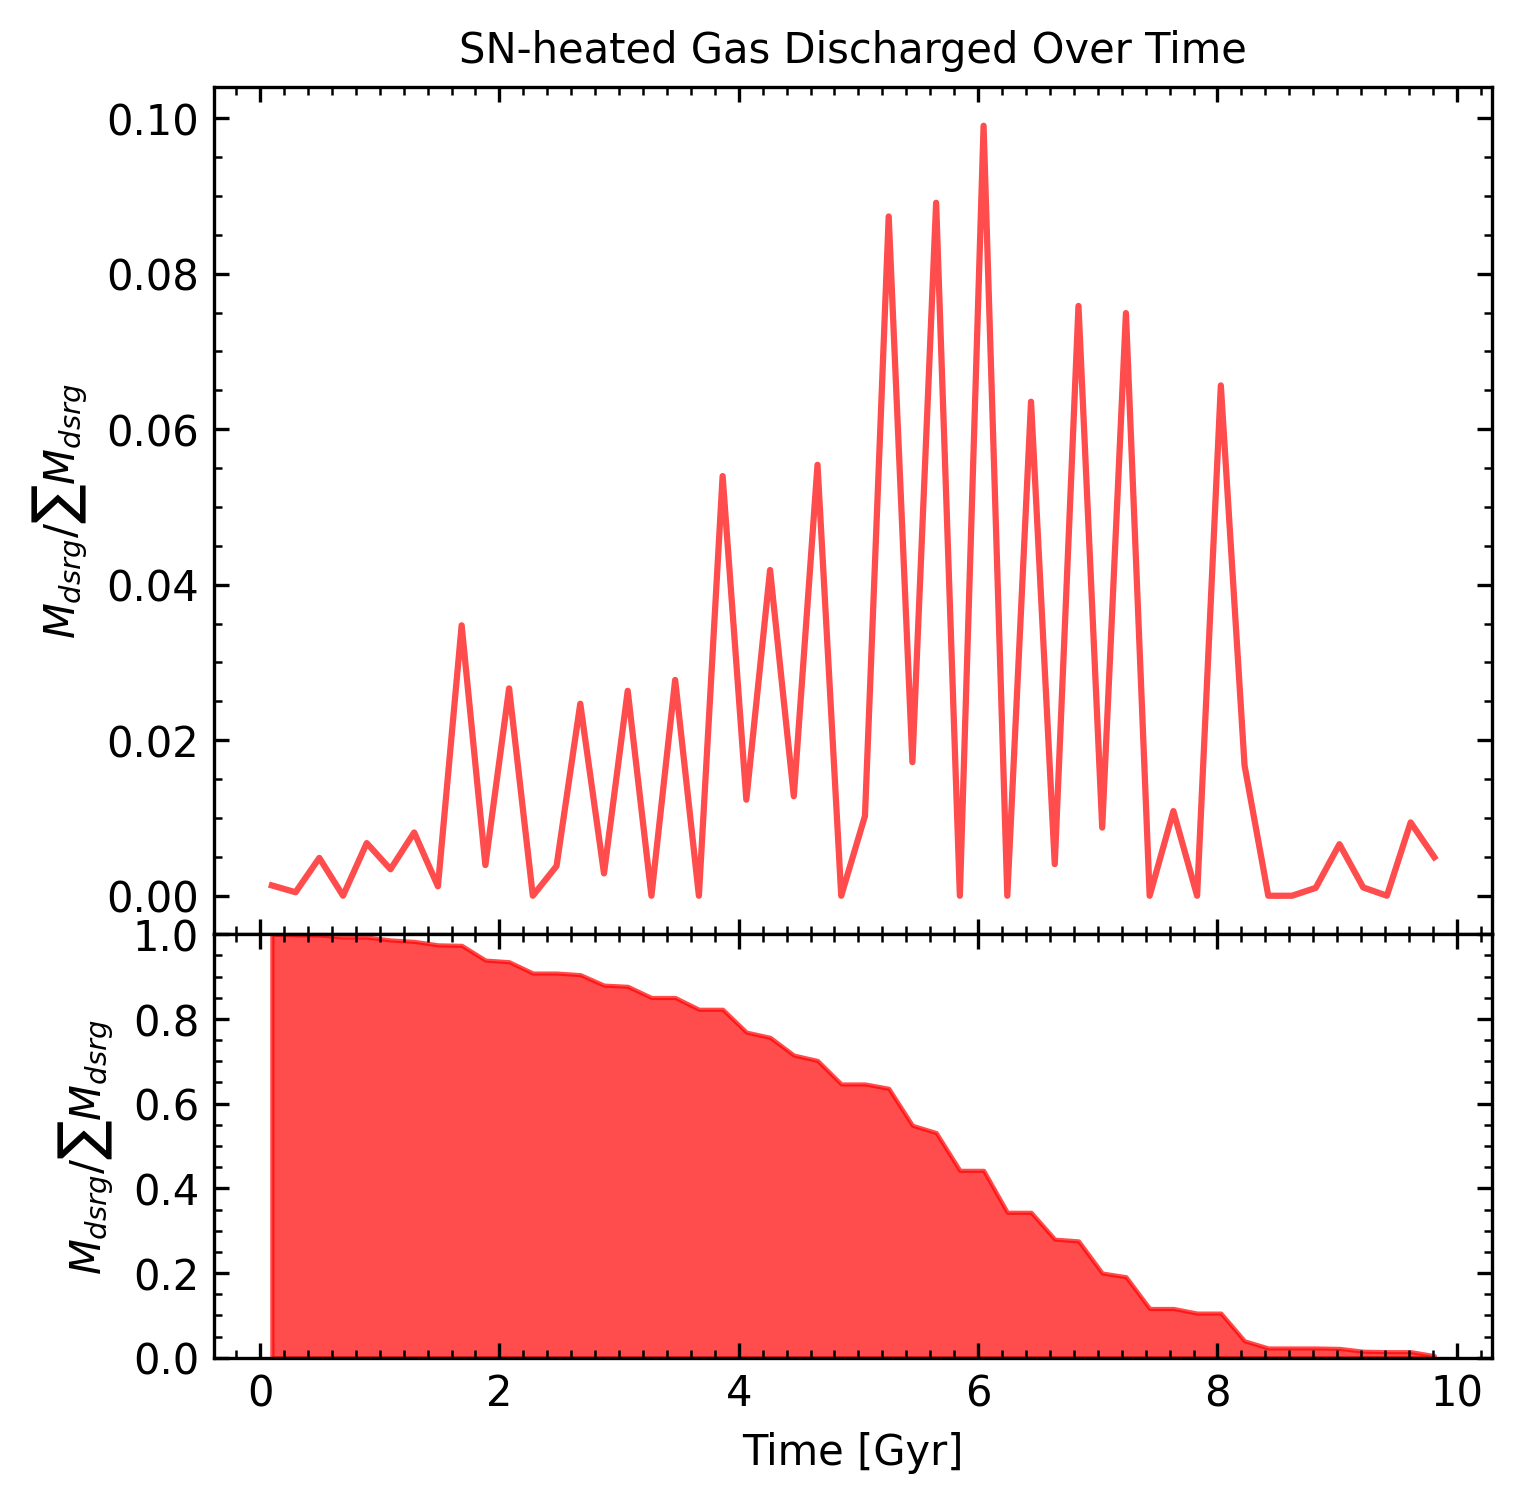

In [49]:
### option 1 ###
################

hot_dsrg = discharged[discharged.snHeated==True]


bins = 50
fig = plt.figure(dpi=300, figsize=(5.5,5.5), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0) 
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)


y1, x = np.histogram(hot_dsrg.time, bins=bins, weights=wt(hot_dsrg))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)

ax0.plot(13.8-bincenters, y1, alpha=0.7, color='r')         
ax1.stackplot(13.8-bincenters, sum1, alpha=0.7, color='r')    

# ax[1].text(0, 0.9, 'Accumulation of Discharged Gas with Infall Distance')


ax0.set_title('SN-heated Gas Discharged Over Time',
              fontsize='medium')
ax0.set_xlabel(r'$PAI / R_{vir}$')
ax0.set_ylabel('$M_{dsrg} / \sum M_{dsrg}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)
                                                                                    
ax0.tick_params(direction='in', which='both', top=True, right=True)
ax0.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax0.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.005))
# ax.grid(alpha=0.1, zorder=-1000)

ax1.set_xlabel('Time [Gyr]')
ax1.set_ylabel('$M_{dsrg} / \sum M_{dsrg}$')
ax1.set_ylim(0,1)
                                                                                    
ax1.tick_params(direction='in', which='both', top=True, right=True)
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

plt.savefig('S22plots/PAIperRvir_sn1.pdf')
plt.show()

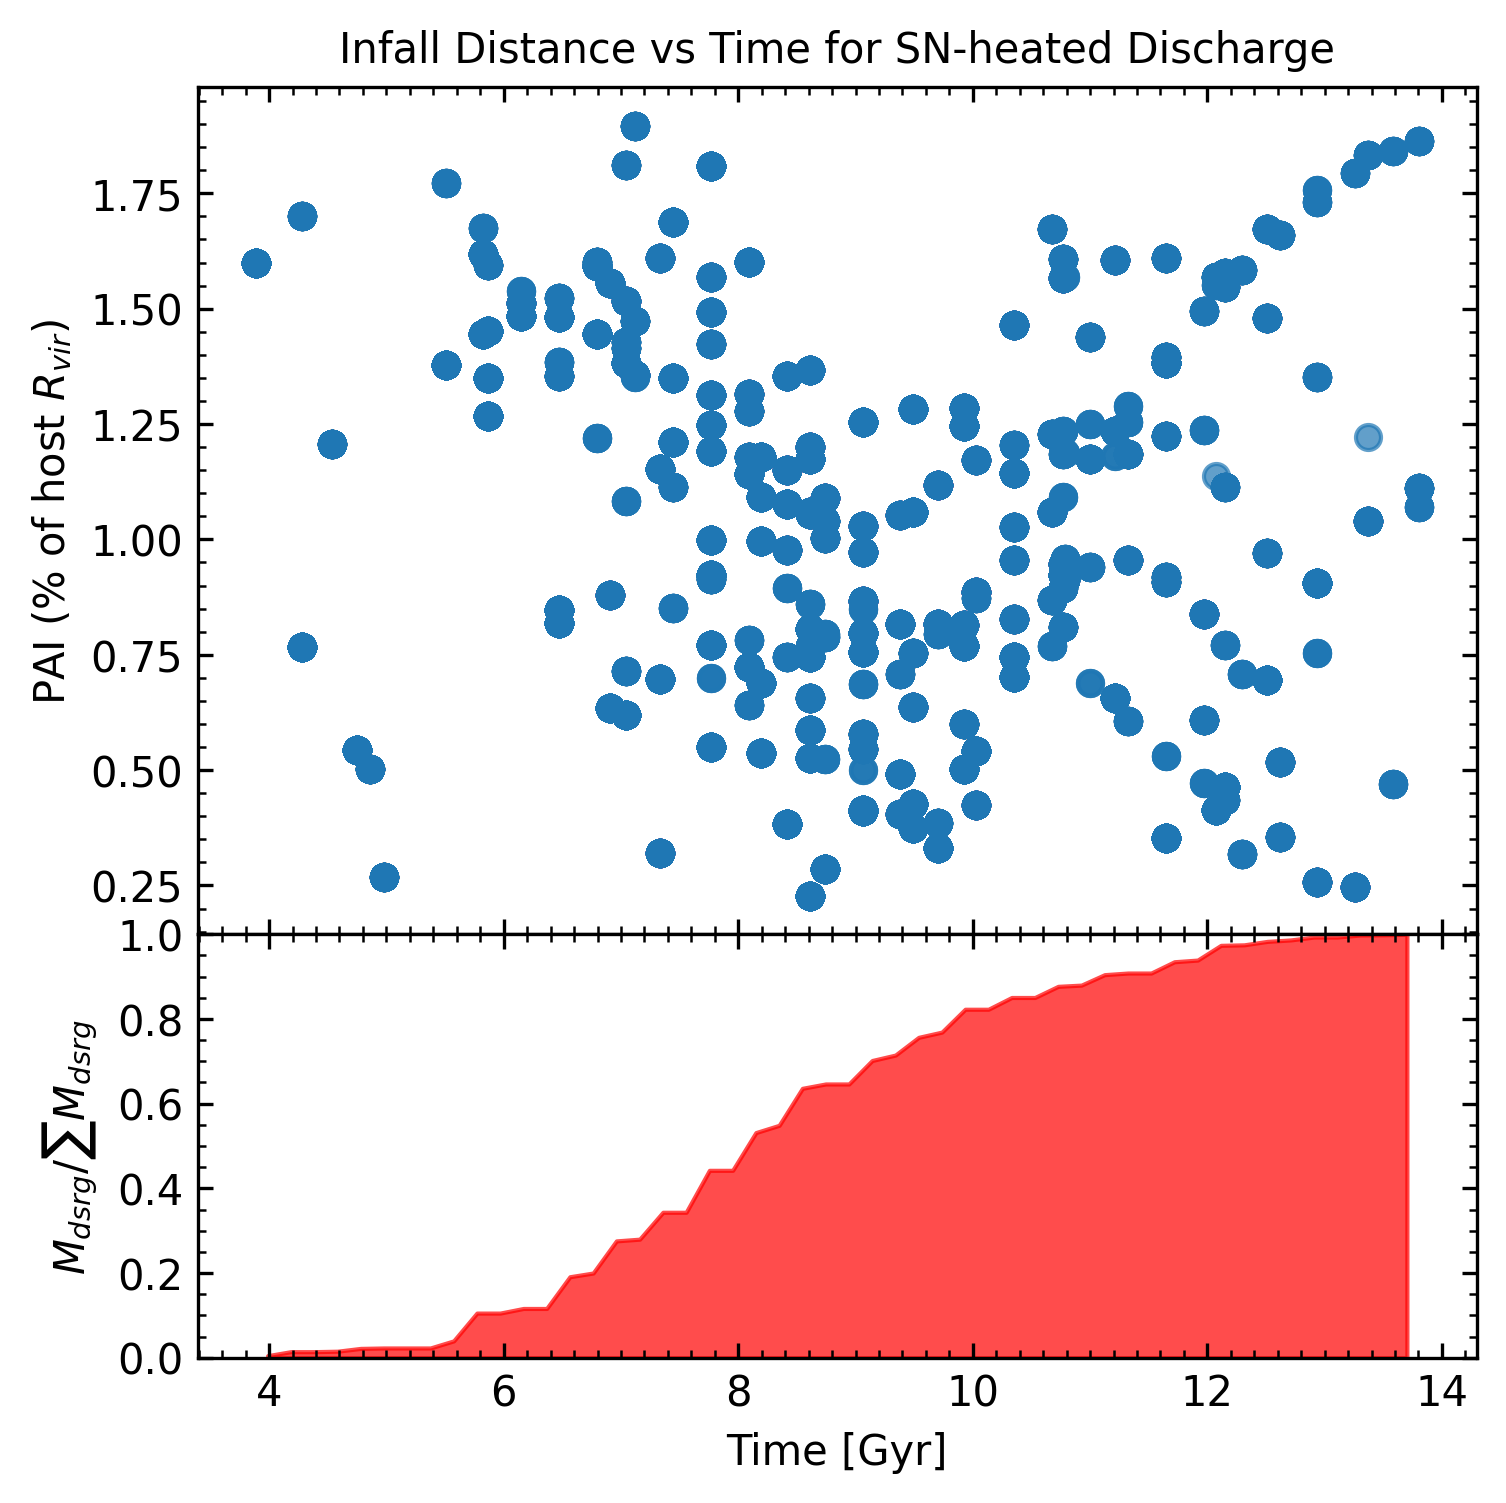

In [50]:
### option 2 ###
################

hot_dsrg = discharged[discharged.snHeated==True]
# hot_dsrg = discharged[discharged.key=='h148_12']

bins = 50
fig = plt.figure(dpi=300, figsize=(5.5,5.5), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0) 
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)

y1, x = np.histogram(hot_dsrg.time, bins=bins, weights=wt(hot_dsrg))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)


ax0.scatter(hot_dsrg.time, pai(hot_dsrg), alpha=0.7) #, color='r')         
ax1.stackplot(bincenters, sum1, alpha=0.7, color='r')    

# ax[1].text(0, 0.9, 'Accumulation of Discharged Gas with Infall Distance')


ax0.set_title('Infall Distance vs Time for SN-heated Discharge',
              fontsize='medium')
ax0.set_xlabel(r'Time')
ax0.set_ylabel('PAI (% of host $R_{vir}$)')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)
                                                                                    
ax0.tick_params(direction='in', which='both', top=True, right=True)
ax0.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
ax0.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
# ax.grid(alpha=0.1, zorder=-1000)

ax1.set_xlabel(r'Time [Gyr]')
ax1.set_ylabel('$M_{dsrg} / \sum M_{dsrg}$')
ax1.set_ylim(0,1)
                                                                                    
ax1.tick_params(direction='in', which='both', top=True, right=True)
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

plt.savefig('S22plots/PAIperRvir_sn2.pdf')
plt.show()

In [25]:
y = np.array(discharged['pid'])  # particle ids of discharged gas...
x = np.array(reaccreted['pid'])  # ...and for reaccreted.

# applying mask:
index = np.argsort(x)
sorted_x = x[index]  # Sorted list of ids pre discharged                        
sorted_index = np.searchsorted(sorted_x, y)
yindex = np.take(index, sorted_index, mode="clip")
mask = x[yindex] != y
result = np.ma.array(yindex, mask=mask)
expelled = discharged.iloc[result[result.mask].data]  # permanently discharged gas.

hot_exp = expelled[expelled['snHeated']==True]  # SN-heated, expelled gas.
cold_exp = expelled[expelled['snHeated']==False]  # unheated, expelled.

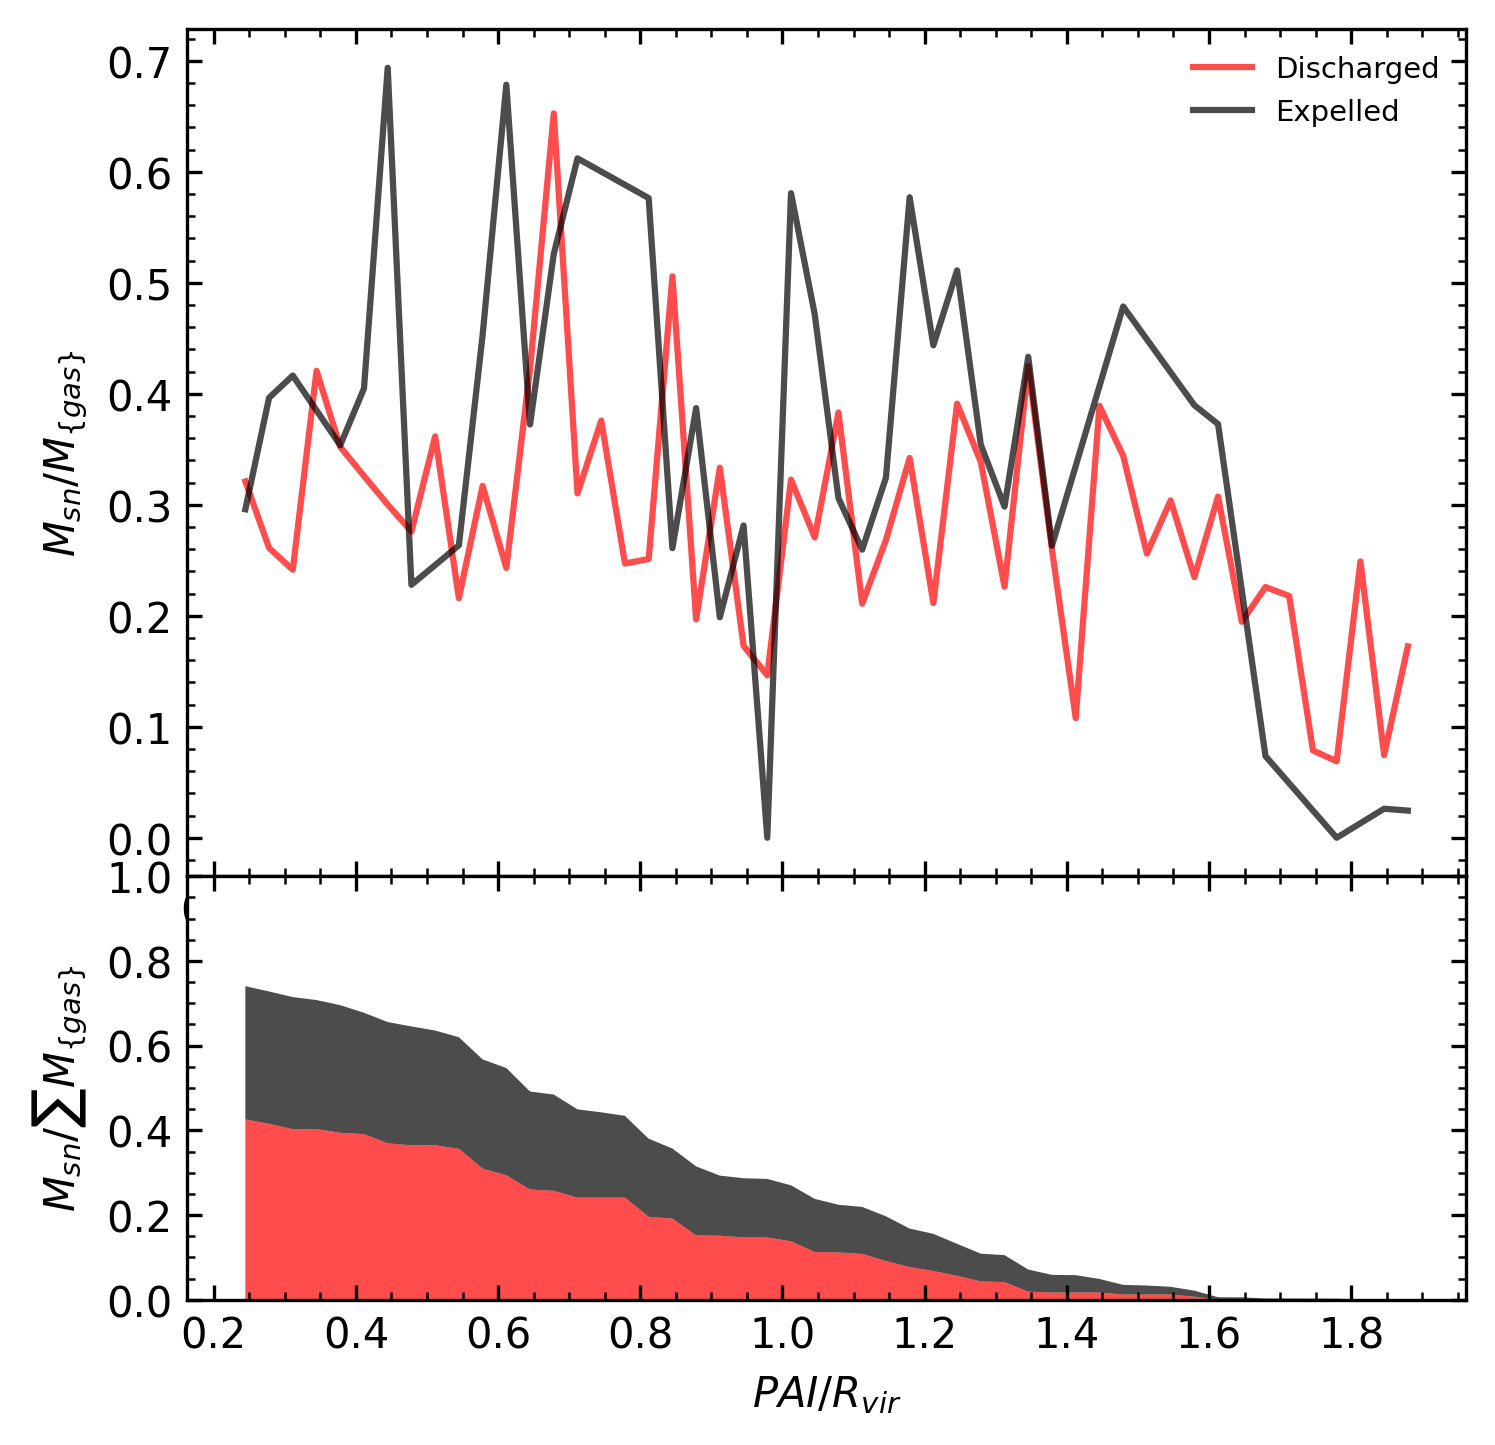

In [74]:
### option 3 ###
################

hot_dsrg = discharged[discharged.snHeated==True]

bins = 50
fig = plt.figure(dpi=300, figsize=(5.5,5.5), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0) 
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)

y1, x = np.histogram(pai(hot_exp), bins=bins, weights=wt(hot_exp, expelled))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(expelled), bins=bins, weights=wt(expelled))
bincenters = 0.5*(x[1:] + x[:-1])
sum2 = np.cumsum(y2)

y3, x = np.histogram(pai(hot_dsrg), bins=bins, weights=wt(hot_dsrg, discharged))
bincenters = 0.5*(x[1:] + x[:-1])
sum3 = np.cumsum(y3)
y4, x = np.histogram(pai(discharged), bins=bins, weights=wt(discharged))
bincenters = 0.5*(x[1:] + x[:-1])
sum4 = np.cumsum(y4)

ax0.plot(bincenters, y3/y4, alpha=0.7, color='r', label='Discharged', zorder=-100)         
ax0.plot(bincenters[y2>0], (y1/y2)[y2>0], alpha=0.7, color='black',
         label='Expelled', zorder=-10)         

ax1.stackplot(bincenters, sum1[-1]-sum1, sum3[-1]-sum3, alpha=0.7,
              colors=['r','black']) 


# ax0.set_title('SN-heating Ratios Over Infall',
#               fontsize='medium')
ax0.set_xlabel(r'$PAI / R_{vir}$')
ax0.set_ylabel('$M_{sn} / M_{\{gas\}}$')
ax0.legend(frameon=False, fontsize=7)
                                                                                    
ax0.tick_params(direction='in', which='both', top=True, right=True)
ax0.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax0.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.02))
# ax.grid(alpha=0.1, zorder=-1000)

ax1.set_xlabel(r'$PAI / R_{vir}$')
ax1.set_ylabel('$M_{sn} / \sum M_{\{gas\}}$')
ax1.set_ylim(0,1)
                                                                                    
ax1.tick_params(direction='in', which='both', top=True, right=True)
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

plt.savefig('S22plots/PAIperRvir_sn3.pdf')
plt.show()

In [104]:
y = np.array(sngas['pid'])  # particle ids of discharged gas...
x = np.array(reaccreted['pid'])  # ...and for reaccreted.

# applying mask:
index = np.argsort(x)
sorted_x = x[index]  # Sorted list of ids pre discharged                        
sorted_index = np.searchsorted(sorted_x, y)
yindex = np.take(index, sorted_index, mode="clip")
mask = x[yindex] != y
result = np.ma.array(yindex, mask=mask)
snexpelled = sngas.iloc[result[result.mask].data]  # permanently discharged gas.

In [116]:
sngas

time      pid        rho          temp          mass  coolontime  \
99277   11.214915  2202002   0.000120  53035.859375  28366.376150   10.908183   
136755  12.507856  2202002   0.000027  16609.818359  29001.936444   12.388833   
99278   11.214915  2205223   0.847933    362.169220  28647.191381   11.088318   
108933  11.645896  2205223   1.566355    206.957672  22046.893610   11.537088   
118382  12.076876  2205223   0.912187    250.799301  22623.037863   11.779229   
...           ...      ...        ...           ...           ...         ...   
7199     8.090307  6630196   0.079972  11086.723633  26645.695937    7.904796   
32353   10.029719  6630196   0.034438   9119.474609  27187.657487   10.015155   
35883   10.352954  6630196   2.164971    172.289948  28162.671901   10.325517   
71775   13.585307  6630396  39.034956  92308.125000  19203.570741   13.613589   
74237   13.800797  6630396   0.016836  30952.648438  18147.511215   13.770997   

                 r  r_per_Rvir           x           y  ...     r_gal  \
99277     6.693904    0.162781    0.587731   -0.193634  ...  0.701493   
136755    8.958103    0.209825    8.207232   -3.552488  ...  0.887741   
99278   381.479873    9.276769 -190.242156  295.517103  ...  0.701493   
108933  383.999876    9.220072 -153.070708  324.781099  ...  0.788523   
118382  395.545115    9.378637 -136.792935  340.590025  ...  0.786147   
...            ...         ...         ...         ...  ...       ...   
7199      0.850678    0.034522    0.807611   -0.085933  ...  0.386238   
32353   205.425662    9.251642   32.981633  -69.574644  ...  0.447104   
35883   261.806191   11.944961   82.854216 -109.039135  ...  0.434821   
71775   558.536138   23.791483  303.043862 -307.217660  ...  0.434821   
74237   575.077073   24.357903  316.942331 -320.379891  ...  0.434821   

        host_r_gal  sat_disk  sat_halo  host_disk  host_halo  other_sat  \
99277    19.302850     False      True      False      False      False   
136755   18.573006     False      True      False      False      False   
99278    19.302850     False     False       True      False      False   
108933   21.124828     False     False       True      False      False   
118382   19.769437     False     False       True      False      False   
...            ...       ...       ...        ...        ...        ...   
7199     11.078115     False      True      False      False      False   
32353     8.270869     False     False      False       True      False   
35883     8.341131     False     False       True      False      False   
71775     3.578876     False     False      False       True      False   
74237     3.589361     False     False      False       True      False   

          IGM  sat_Mvir      key  
99277   False       NaN  h148_12  
136755  False       NaN  h148_12  
99278   False       NaN  h148_12  
108933  False       NaN  h148_12  
118382  False       NaN  h148_12  
...       ...       ...      ...  
7199    False       NaN  h329_29  
32353   False       NaN  h329_29  
35883   False       NaN  h329_29  
71775   False       NaN  h329_29  
74237   False       NaN  h329_29  

[527233 rows x 62 columns]

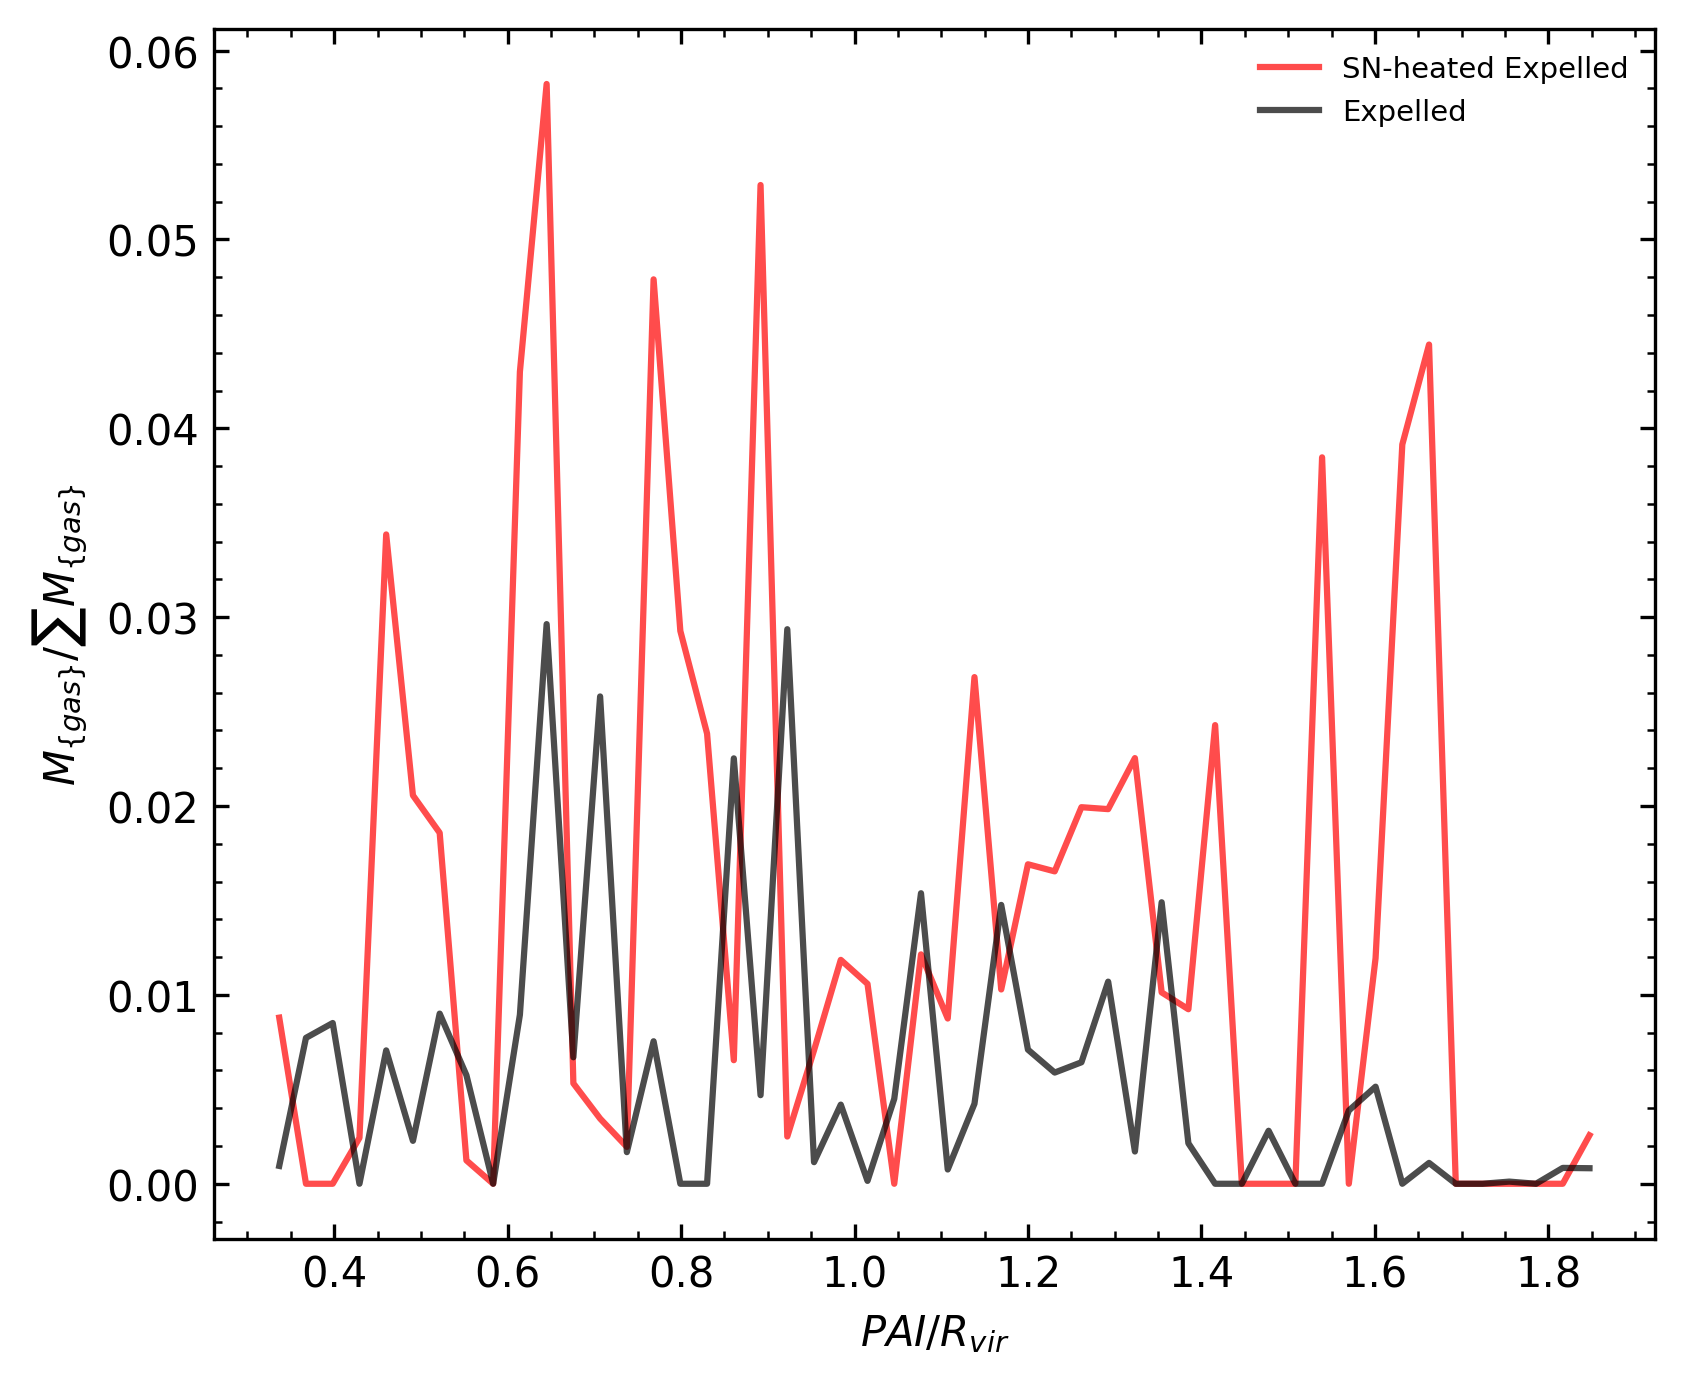

In [106]:
### option 4 ###
################

bins = 50
fig, ax = plt.subplots(1,1, dpi=300, figsize=(5.5,4.5), constrained_layout=True)


y1, x = np.histogram(pai(snexpelled), bins=bins, weights=wt(snexpelled, sngas))
bincenters = 0.5*(x[1:] + x[:-1])
# sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(expelled), bins=bins, weights=wt(expelled,discharged))
bincenters = 0.5*(x[1:] + x[:-1])
# sum2 = np.cumsum(y2)

ax.plot(bincenters, y1, alpha=0.7, color='red',
         label='SN-heated Expelled')
ax.plot(bincenters, y2, alpha=0.7, color='black',
         label='Expelled')    

# ax.set_title('SN-heating Ratios Over Infall',
#               fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{sn} / M_{\{gas\}}$')
ax.legend(frameon=False, fontsize=7)
                                                                                    
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.002))

ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
# ax.set_ylim(0,1)

plt.savefig('S22plots/PAIperRvir_ratios.pdf')
plt.show()

### Assessment of Satellite Outflows: <a class="anchor" id="outflow"></a>

___


In [12]:
# pulling SFR Data
keys = get_keys()
sfrData = pd.DataFrame([])

for key in keys:   
    sim = key[:4]
    haloid = int(key[5:])

    data = pd.read_csv(f'{rootPath}Stellar_Feedback_Code/SFRData/{sim}_{haloid}sfh.txt',
                       sep=' ')
    data = data.iloc[:,[0,1]]  # dropping erroneous columns.
    data['key'] = key
    data = data.rename({'#':'time', 'Time':'sfr'}, axis='columns')

    sfrData = pd.concat([sfrData, data])
    

# pulling data on all tracked gas in selected satellites into df.
allGas = pd.DataFrame()   

for i,key in enumerate(keys):
    i += 1
    sim = key[:4]
    haloid = int(key[5:])
    allGas1 = pd.read_hdf(f'{rootPath}Stellar_Feedback_Code/SNeData/all_particles.hdf5',
                          key=key)
    allGas1['key'] = key
    allGas = pd.concat([allGas, allGas1])

In [ ]:
# generating hdf5 of satellite data with infall times, etc. #
### do no need to run again ###
# key for points at infall:
allGas['pai'] = pai(allGas)

allGas['host'] = [x[:4] for x in np.array(allGas['key'])]
allGas['sat'] = [x[5:] for x in np.array(allGas['key'])]

keys = get_keys()

for key in tqdm.tqdm(keys):
    gas = allGas[allGas.key==key]
    
    time = np.unique(gas.time)
    t_start = [gas.time.min()] * len(time)
    t_infall = [gas[gas.pai<1].max().time] * len(time)
    key1 = [key] * len(time)
    # collecting into dataframe.
    satdat = pd.DataFrame(np.array([key1, time, np.unique(pai(gas)), t_start, 
                                    t_infall]).T,
                          columns=['key', 'time', 'pai', 't_start', 't_infall'])
    
    # saving to hdf.
    filepath = f'{rootPath}Stellar_Feedback_Code/SNeData/satdat.hdf5'
    satdat.to_hdf(filepath, key=key)

In [14]:
# importing satellite data so we have infall times:
keys = get_keys()

satdat = pd.DataFrame([])

for key in keys:
    satdat1 = pd.read_hdf(f'{rootPath}Stellar_Feedback_Code/SNeData/satdat.hdf5',
                          key=key)
    satdat1 = satdat1.astype({'time': float, 'pai': float, 't_start': float,
                              't_infall': float})
    
    satdat = pd.concat([satdat, satdat1])

In [15]:
@pynbody.derived_array
def infall(gas, key):
    gas1 = gas[gas.key==key]  # will get errors if not using array of all gas.
    gas1 = gas1.sort_values(by=['time'])
    
#     pai1 = np.unique(pai(gas))
    pai1 = np.unique(gas1.pai)
    time = np.unique(gas1.time)

    f = interpolate.interp1d(pai1, time)

    tneq=f(1)
    return tnew  # finding time when at 1 Rvir of host 

In [42]:
np.unique(satdat.t_infall)
satdat['time'] = satdat['time'].astype(float)


discharged.key

99277     h148_12
136755    h148_12
59821     h148_12
79674     h148_12
99281     h148_12
           ...   
7184      h329_29
25187     h329_29
10792     h329_29
21595     h329_29
7199      h329_29
Name: key, Length: 192116, dtype: object

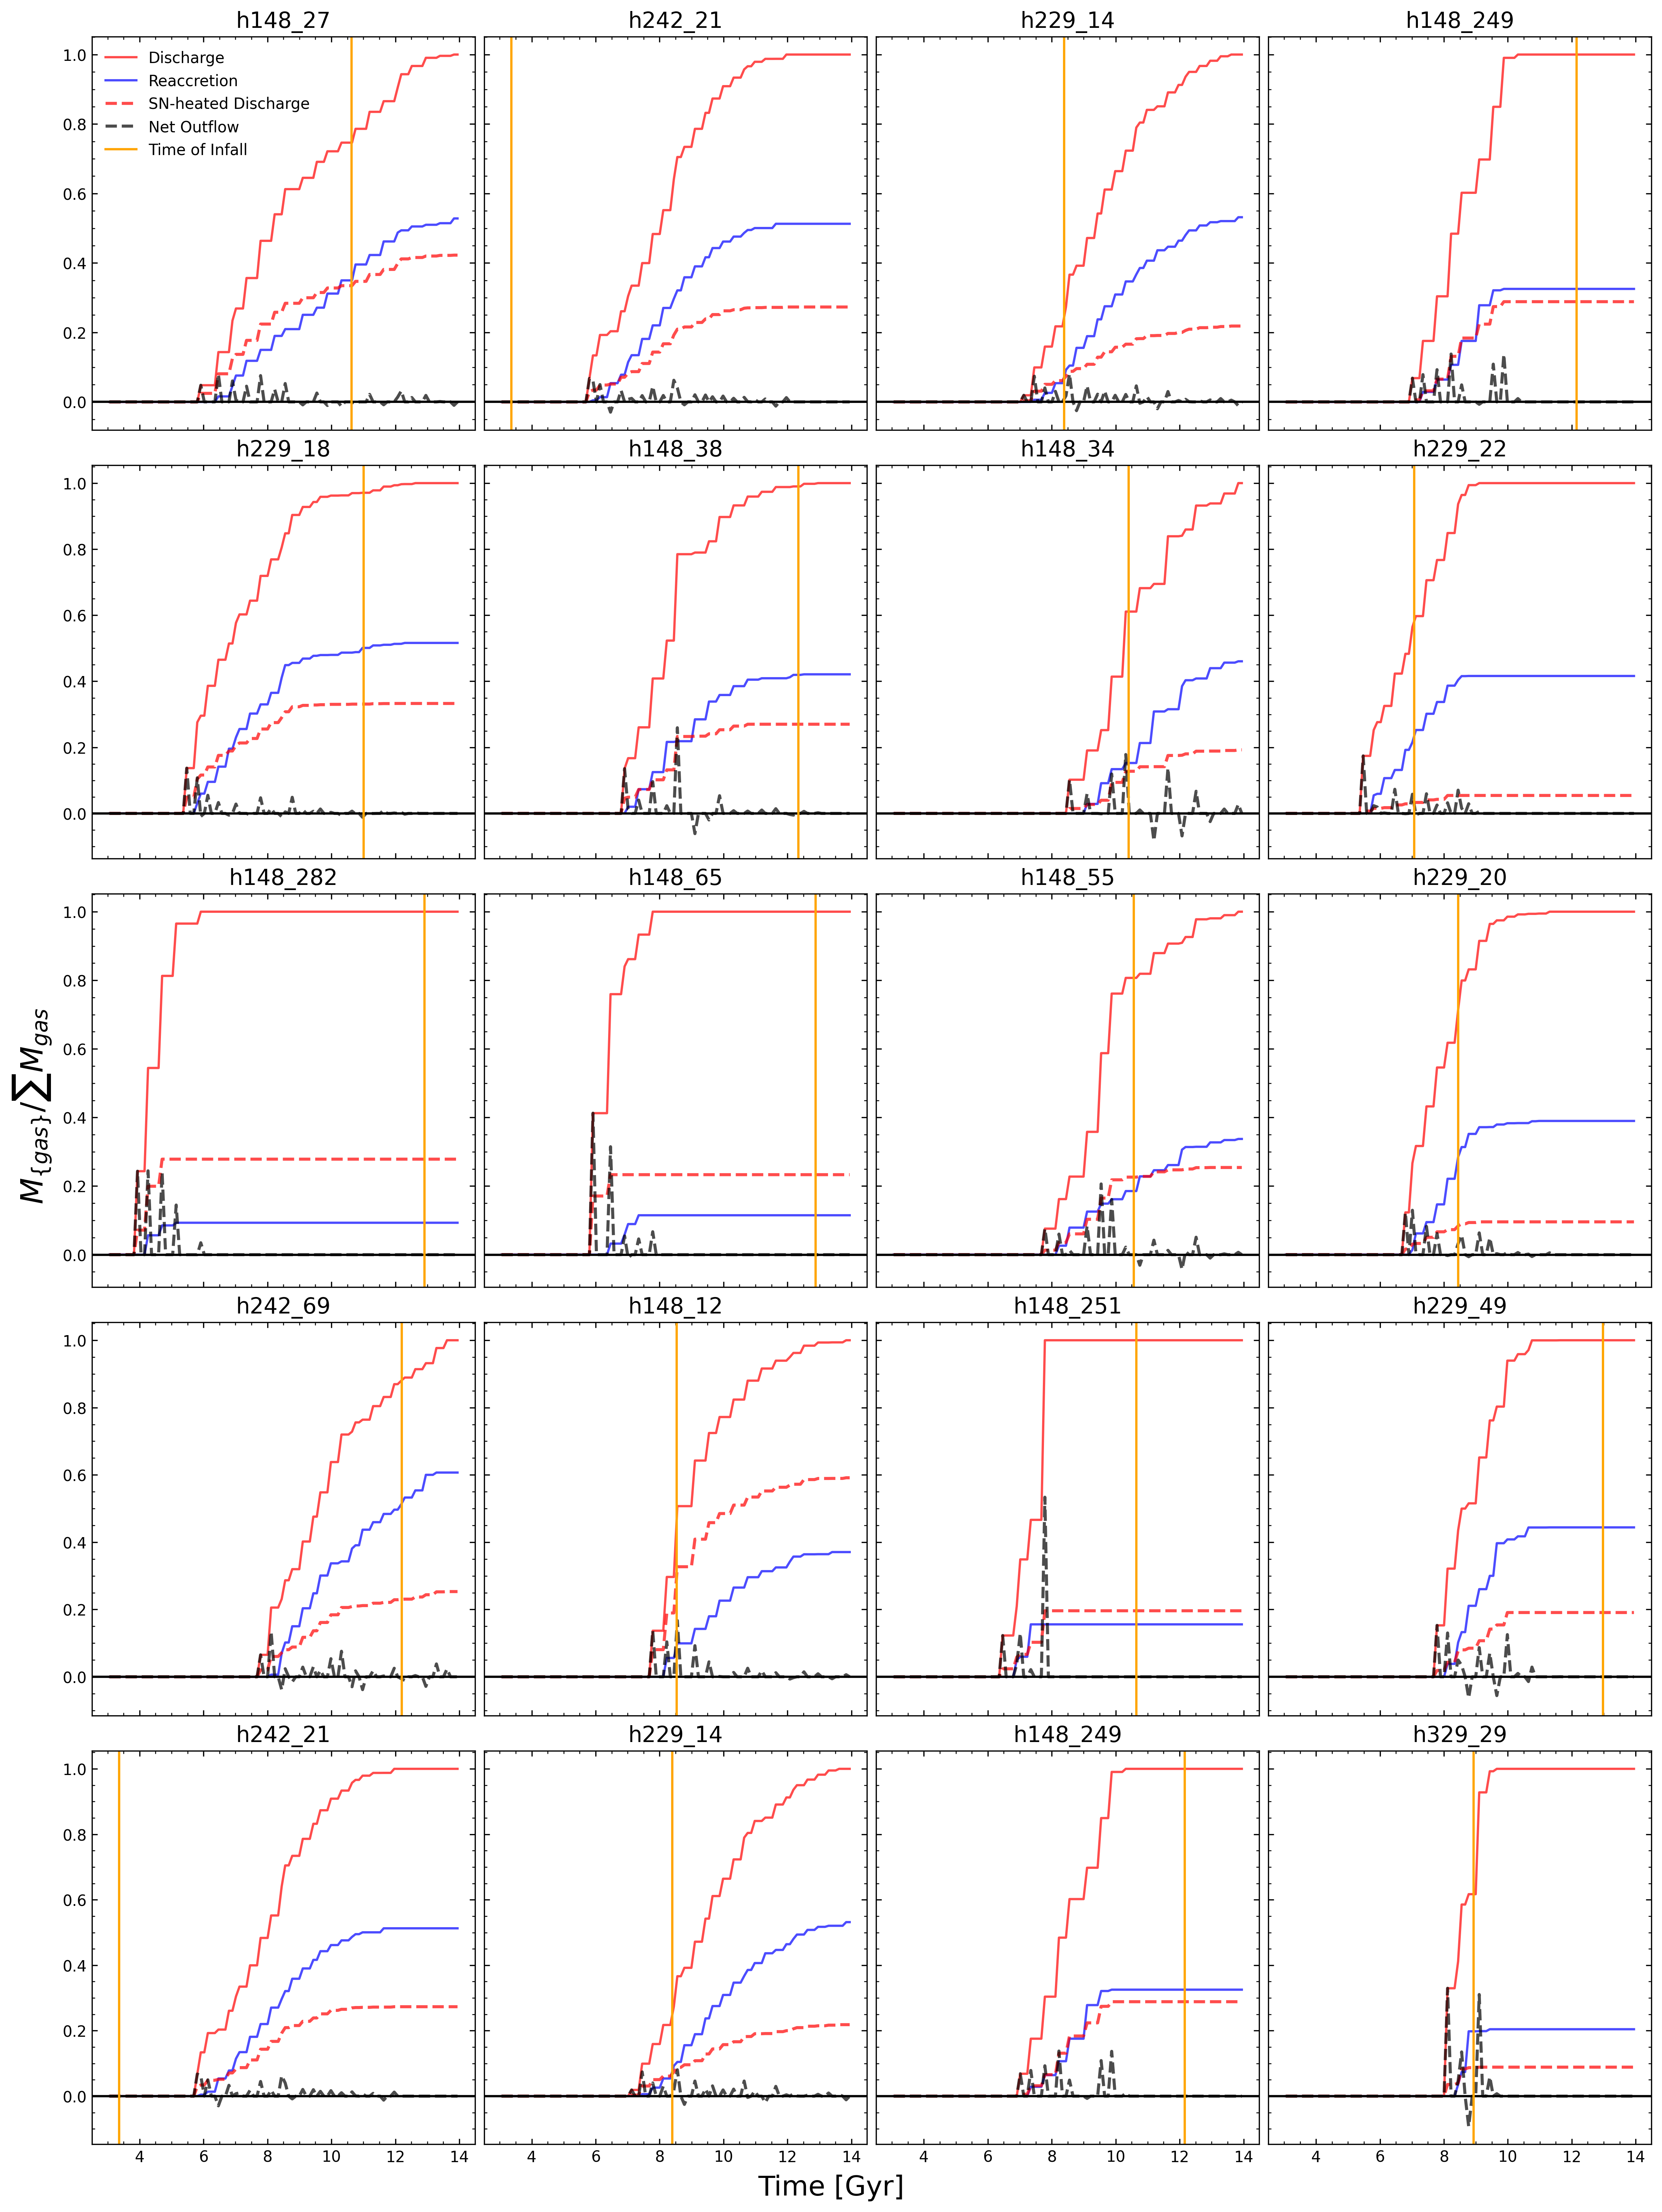

In [120]:
# panels for each satellite comparing discharged, reaccreted, and the difference.
bins = 100
fig, ax = plt.subplots(5, 4, dpi=300, figsize=(15,20), sharex='col', sharey='row',
                       constrained_layout=True)  # figsize=(20,10)

keys = keys_mass #get_keys()

for i in range(5): 
    for j in range(0,4):
        k = 4*j + i  # flip i and j until we have a 20th satellite.
        
        dsrg = discharged[discharged['key']==keys[k]]  # discharged gas.
        reac = reaccreted[reaccreted['key']==keys[k]]  # reaccreted.
        infall = float(np.unique(satdat[satdat.key==keys[k]].t_infall))  # time of infall. 
        
        offset = 0  # set to change x-axis offset.
        
        y1, x = np.histogram(dsrg['time'], bins=bins, weights=wt(dsrg), range=(3, 14))
        bincenters = 0.5*(x[1:] + x[:-1]) - offset
        sum1 = np.cumsum(y1)
        y2, x = np.histogram(reac['time'], bins=bins, weights=wt(reac, dsrg),
                             range=(3, 14))
        sum2 = np.cumsum(y2)
        heated = dsrg[dsrg['snHeated']==True]
        y3, x = np.histogram(heated['time'], bins=bins, weights=wt(heated,dsrg),
                             range=(3, 14))
        sum3 = np.cumsum(y3)

        ax[i, j].plot(bincenters-offset, sum1, alpha=0.7, color='r', label='Discharge')
        ax[i, j].plot(bincenters-offset, sum2, alpha=0.7, color='b', label='Reaccretion')
        ax[i, j].plot(bincenters-offset, sum3, alpha=0.7, linestyle='--', color='red',
                   linewidth=2,label='SN-heated Discharge')      
        ax[i, j].plot(bincenters-offset, y1-y2, alpha=0.7, linestyle='--', color='black',
                   linewidth=2,label='Net Outflow')
        
        ax[i, j].axhline(y=0, color='black')  # horizontal line representing 0 outflow.
        ax[i, j].axvline(x = infall-offset, color = 'orange',
                         label = 'Time of Infall')  # vert. for time of infall.
        
        # setting axes, titles, etc.
        ax[i, j].set_title(f'{keys[k]}', fontsize='x-large')
        
        ax[i, j].tick_params(direction='in', which='both', top=True, right=True)
        ax[i, j].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
        ax[i, j].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
        
#         ax[i, j].set_ylim(-0.65,0.65)

# fig.suptitle('Gas Outflows Over Time', fontsize=26)
fig.supxlabel('Time [Gyr]', fontsize=18)
fig.supylabel('$M_{\{gas\}} / \sum M_{gas}$', fontsize=20)

ax[0, 0].legend(frameon=False, fontsize='medium', loc='best')

plt.savefig('S22plots/DvsR_panel.pdf')        
plt.show()

In [52]:
# # panels for each satellite comparing discharged, reaccreted, and the difference.
# bins = 100
# fig, ax = plt.subplots(1, 1, dpi=300, figsize=(7,4), sharex='col', sharey='row',
#                        constrained_layout=True)  # figsize=(20,10)

# key = 'h148_27'


# dsrg = discharged[discharged['key']==key]  # discharged gas.
# reac = reaccreted[reaccreted['key']==key]  # reaccreted.
# infall = float(np.unique(satdat[satdat.key==key].t_infall))  # time of infall. 

# offset = 0 #-13.8  # set to change x-axis offset.

# y1, x = np.histogram(dsrg['time'], bins=bins, weights=wt(dsrg), range=(3, 14))
# bincenters = 0.5*(x[1:] + x[:-1]) - offset
# sum1 = np.cumsum(y1)
# y2, x = np.histogram(reac['time'], bins=bins, weights=wt(reac, dsrg),
#                      range=(3, 14))
# sum2 = np.cumsum(y2)
# heated = dsrg[dsrg['snHeated']==True]
# y3, x = np.histogram(heated['time'], bins=bins, weights=wt(heated,dsrg),
#                      range=(3, 14))
# sum3 = np.cumsum(y3)

# ax.plot(bincenters-offset, sum1, alpha=0.7, color='r', label='Discharge')
# ax.plot(bincenters-offset, sum2, alpha=0.7, color='b', label='Reaccretion')
# ax.plot(bincenters-offset, sum3, alpha=0.7, linestyle='--', color='red',
#            linewidth=2,label='SN-heated Discharge')
# ax.plot(bincenters-offset, y1-y2, alpha=0.7, linestyle='--', color='black',
#            linewidth=2,label='Net Outflow')


# time = sfrData[sfrData.key==key].time
# sfr = sfrData[sfrData.key==key].sfr


# ax.plot(time, sfr*10, alpha=0.7, linestyle='-', color='green',
#            linewidth=2,label='sfr')


# ax.axhline(y=0, color='black')  # horizontal line representing 0 outflow.
# ax.axvline(x = infall-offset, color = 'orange',
#                  label = 'Time of Infall')  # vert. for time of infall.

# # setting axes, titles, etc.
# # ax.set_title(f'{key}', fontsize='x-large')

# ax.tick_params(direction='in', which='both', top=True, right=True)
# ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
# ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

# # fig.suptitle('Gas Outflows Over Time', fontsize=26)
# # fig.supxlabel('Time (Gyrs)', fontsize=26)
# # fig.supylabel('$M_{\{gas\}} / \sum M_{gas}$', fontsize=26)

# ax.legend(frameon=False, fontsize='medium', loc='best')

# plt.savefig('S22plots/DvsR_panel.pdf')        

# plt.show()

NameError: name 'sfrData' is not defined

In [ ]:
dat = discharged['']

#### Notes From Friday Meeting

`and order sats by mass`

`and box on each plot with mass`

`and change y to just gas`

### Sorting Satellites by Mass

---

Need to get sat_Mvir working

In [26]:
# keys = get_keys()

# for key in tqdm.tqdm(keys):
#     gas = allGas[allGas.key==key]
#     total = gas.mass.sum()  # total gas mass at beginning of sim.
    

time      pid       rho           temp          mass  coolontime  \
0       7.336092  2202002  0.000068  701308.937500  27934.820603    1.502397   
1       7.336092  2205223  0.000057  382338.750000  26567.141174    0.000000   
2       7.336092  2857672  0.000078  836052.812500  26511.576364    0.000000   
3       7.336092  4057198  0.000013  292871.562500  26510.536704    0.000000   
4       7.336092  4073949  0.000012  279253.875000  26510.536704    0.000000   
...          ...      ...       ...            ...           ...         ...   
74234  13.800797  6630145  0.005559   14567.006836  26513.241201    0.000000   
74235  13.800797  6630163  0.000211  733413.437500  26510.797482    0.000000   
74236  13.800797  6630180  0.000051  311438.656250  26511.313858    0.000000   
74237  13.800797  6630396  0.016836   30952.648438  18147.511215   13.770997   
74238  13.800797  6631018  0.000074  163944.765625  26514.254956    0.000000   

                r  r_per_Rvir           x           y  ...     r_gal  \
0      261.143007    6.430942  261.088950   -4.107458  ...  0.873838   
1      184.262677    4.537677  176.898108    4.908622  ...  0.873838   
2      266.172884    6.554808  260.439281  -46.928931  ...  0.873838   
3      492.084772   12.118144  457.221555 -179.116478  ...  0.873838   
4      489.344154   12.050653  451.691340 -187.419686  ...  0.873838   
...           ...         ...         ...         ...  ...       ...   
74234  566.925483   24.012635  313.253921 -300.150447  ...  0.434821   
74235  543.753388   23.031160  324.145180 -275.373914  ...  0.434821   
74236  515.814452   21.847781  343.047861 -288.564422  ...  0.434821   
74237  575.077073   24.357903  316.942331 -320.379891  ...  0.434821   
74238  623.492658   26.408588  367.847678 -404.909708  ...  0.434821   

       host_r_gal  sat_disk  sat_halo  host_disk  host_halo  other_sat    IGM  \
0       20.918000     False     False      False       True      False  False   
1       20.918000     False     False      False      False      False   True   
2       20.918000     False     False      False       True      False  False   
3       20.918000     False     False      False      False      False   True   
4       20.918000     False     False      False      False      False   True   
...           ...       ...       ...        ...        ...        ...    ...   
74234    3.589361     False     False      False       True      False  False   
74235    3.589361     False     False      False       True      False  False   
74236    3.589361     False     False      False       True      False  False   
74237    3.589361     False     False      False       True      False  False   
74238    3.589361     False     False      False       True      False  False   

       sat_Mvir      key  
0           NaN  h148_12  
1           NaN  h148_12  
2           NaN  h148_12  
3           NaN  h148_12  
4           NaN  h148_12  
...         ...      ...  
74234       NaN  h329_29  
74235       NaN  h329_29  
74236       NaN  h329_29  
74237       NaN  h329_29  
74238       NaN  h329_29  

[3875390 rows x 62 columns]

In [99]:
allGas.keys()

Index(['time', 'pid', 'rho', 'temp', 'mass', 'coolontime', 'r', 'r_per_Rvir',
       'x', 'y', 'z', 'satRvir', 'a', 'vx', 'vy', 'vz', 'v', 'r_rel_host',
       'r_rel_host_per_Rvir', 'x_rel_host', 'y_rel_host', 'z_rel_host',
       'hostRvir', 'vx_rel_host', 'vy_rel_host', 'vz_rel_host', 'v_rel_host',
       'sat_Xc', 'sat_Yc', 'sat_Zc', 'sat_vx', 'sat_vy', 'sat_vz', 'host_Xc',
       'host_Yc', 'host_Zc', 'host_vx', 'host_vy', 'host_vz', 'sat_Mstar',
       'sat_Mgas', 'host_Mstar', 'host_Mgas', 'sat_r_half', 'sat_r_gas',
       'host_r_half', 'host_r_gas', 'in_sat', 'in_host', 'in_other_sat',
       'in_IGM', 'dt', 'r_gal', 'host_r_gal', 'sat_disk', 'sat_halo',
       'host_disk', 'host_halo', 'other_sat', 'IGM', 'sat_Mvir', 'key'],
      dtype='object')